# Deep Learning 2023 - Coursework
## Classifying Plankton!

In [ ]:
!pip3 install ax-platform 

In [ ]:
import os
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import torch
import torch.nn as nn
import torch.nn.functional as F

# Additional torch imports
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
import torchvision
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models

# Sci-kit learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Python imports
import collections
import random
import datetime
import copy
import zipfile


In [ ]:
import zipfile
from pathlib import Path
# create a Path object with the path to the file
path = Path('./plankton.pt')

# Loading the data
if not path.is_file():
    # we will use the zip file to get the dataset archive
    with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
        zip_ref.extractall()
        

In [ ]:
# Clone model weights repo
!git clone https://stgit.dcs.gla.ac.uk/2379875n/deep-learning-coursework-2023.git

In [ ]:
RANDOM_STATE = 10

torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

TRAINING = True # If TRAINING = True, model will be trained; If TRAINING = False, model will be preset with trained weights
MODEL_WEIGHT_PATH = "model_weights"

use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [ ]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import train, evaluate

init_notebook_plotting()

In [ ]:
# some boilerplate to make things render on colab
import plotly.io as pio
pio.renderers.default = 'colab'
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
configure_plotly_browser_state()

### Data 

#### Visualise dataset

In [ ]:
data = torch.load('plankton.pt')

# get the number of different classes
classes = data['labels'].unique()
nclasses = len(classes)
print('The classes in this dataset are: ')
print(classes)

# display the number of instances per class: 
print('\nAnd the numbers of examples per class are: ')
print( pd.Series(data['labels']).value_counts() )

# display the class names
print(data["names"])

The classes in this dataset are: 
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

And the numbers of examples per class are: 
2.0     257
8.0     235
7.0     219
10.0    157
11.0    135
0.0     134
3.0     110
6.0      92
9.0      76
4.0      70
5.0      67
1.0      65
dtype: int64
{'Stephanopyxis': 0, 'Odontella': 1, 'Parafavella': 2, 'Lauderia': 3, 'Barnacle nauplii': 4, 'Acantharians': 5, 'C lineatum': 6, 'Rhizosolenia': 7, 'C fusus': 8, 'Halosphaera': 9, 'Leptocylndrus': 10, 'Oligortrich ciliate': 11}


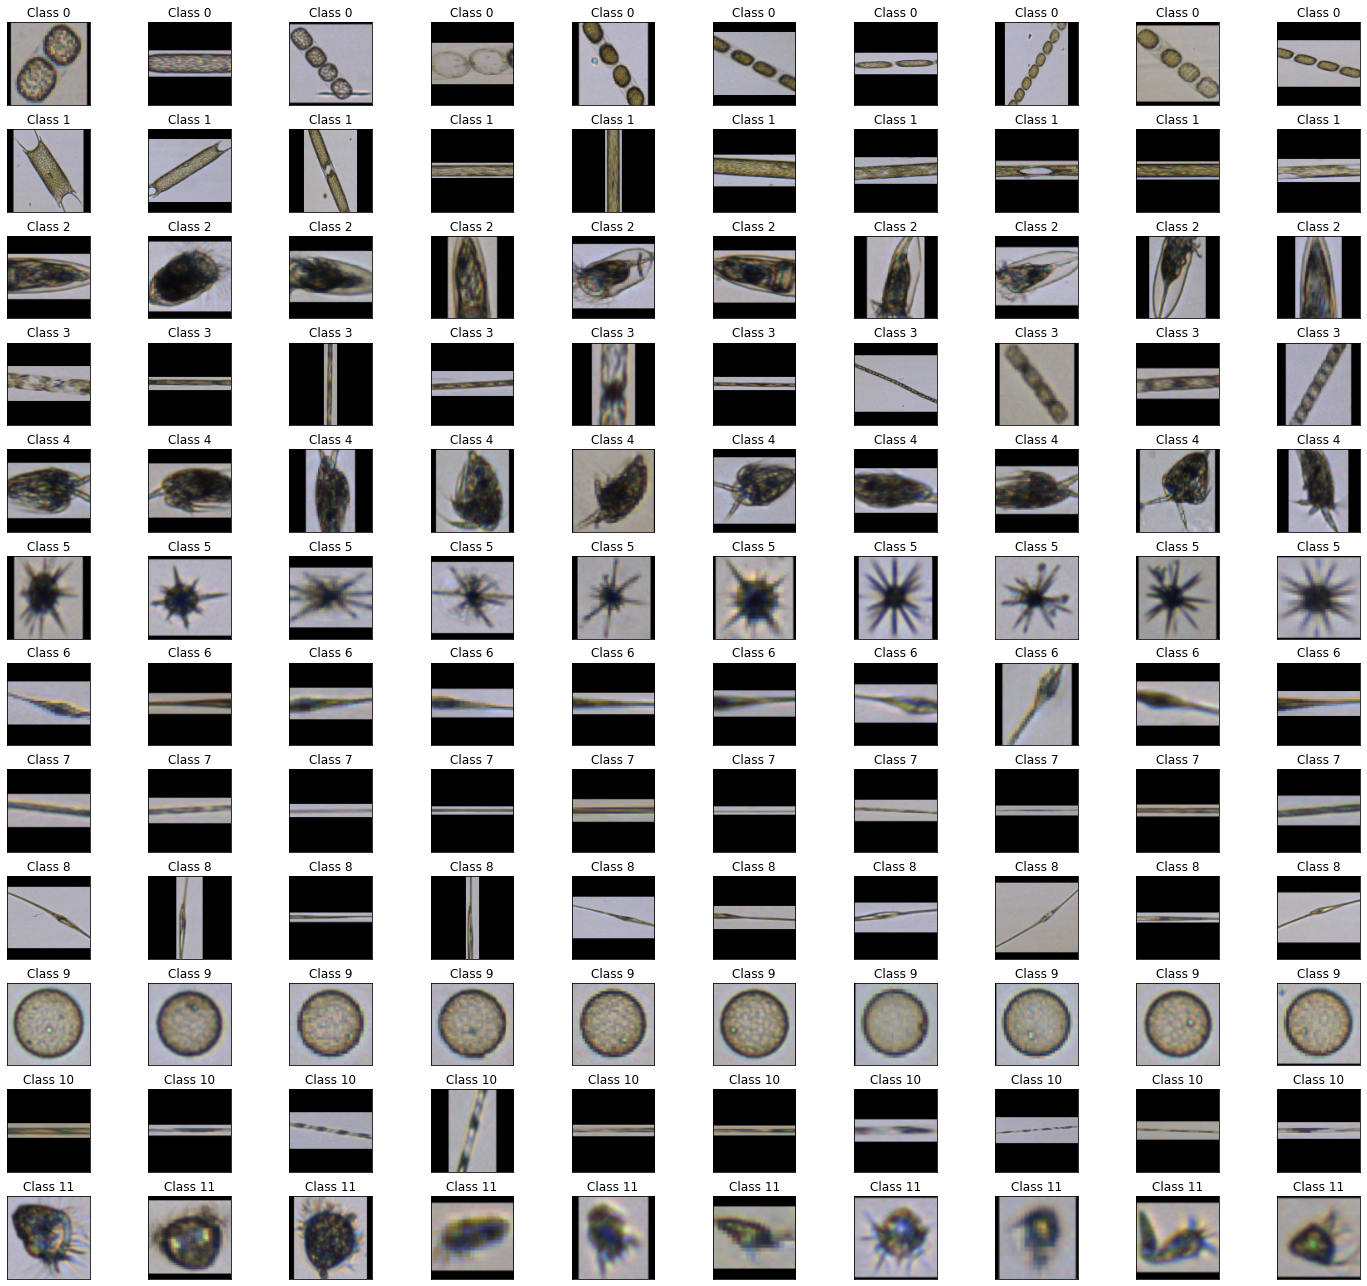

In [ ]:
# we now print some examples from each class for visualisation
fig = plt.figure(figsize=(20,20))

n = 10 # number of examples to show per class

for i in range(nclasses): 
  idx = data['labels'] == classes[i]
  imgs = data['images'][idx,...]
  for j in range(n):
    ax = plt.subplot(nclasses,n,i*n+j+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Class {i}')
    ax.imshow( imgs[j,...].permute(1, 2, 0) ) # note the permute because tensorflow puts the channel as the first dimension whereas matplotlib expects WxHx3
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

#### Observations on the data

* Easily able to flip, rotate data as there doesn't seem to be a natural side up
* Quite a few of the classes that are a similar shape (0,1,3,6,7,8,10 - a straight line) (2,4,11 - more bug like). We will have to be careful that we don't oversimplify the features. The rest of the classes seem different enough and I feel will be less of a problem.
* Dataset classes are small and imbalanced


### Split dataset

We initially split our dataset into a train/test/validation split with a 60:20:20 ratio.

We have used the stratify parameter to ensures that the same proportion of each target class is present in both the training, testing and validation sets.

In [ ]:
X = data["images"]
y = data["labels"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid  = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=RANDOM_STATE) # 0.25 x 0.8 = 0.2

In [ ]:
np.unique(y_train, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       dtype=float32),
 array([ 80,  39, 154,  66,  42,  40,  55, 131, 141,  46,  94,  81]))

### Plankton dataset

#### Overview

Throughout completing this coursework, we have made gradual improvements to the Dataset class to improve our model's results.

Our Dataset class includes 3 key additional operations in addition to the basic functionality of storing the samples and their corresponding labels. These include:

* Data augmentation
* Pre-processing
* Sampling

#### Data augmentation

To increase the size of our dataset, we have utilised data augmentation strategies. These include flipping, rotating, cropping, affine, elastic and perspective transformations. Each transformation has been chosen after observing the data.

* As the data has no natural side up, we can easily flip and rotate the data. Hence we used horizontal and vertical flipping transformations and the random rotation transformation. This allows us to generate three additional images from the original base image.
* To help generalise the dataset further, while increasing the number of training instances, we have also used a resized cropping transformation which crops an image and then resizes our image to the required size. By including resized cropping transformations we  hope to be able to generalise the dataset better. We can see that quite a few of the target classes, including class 0 and 1, often already include cropped results. This transformation allows us to generate an additional image from the original base image.
* The last three transformations we have used to augment the dataset are random affine, elastic and random perspective transformations. These transformations are also used to help generalise the the dataset and avoid overfitting the models. The random affine and perspective transformation change the perspective of the input image. The elastic transformation adds a see-through-water-like effect to the image. These transfomations allows us to generate three additional images from the original base image.

In total, our data augmentation strategy allows us to generate 7 additional images from the orginal base image. This means, even for class 1 in our training dataset (the class with the least number of training samples), with only 39 training samples, we can increase our training samples size to 312.

#### Pre-processing

We pre-process each image before training and testing our model. Depending on the model, the pre-processing steps vary slightly.

**Standard pre-proccessing steps**

Unless otherwise specificed, we will run these pre-processing steps on each image. These include:

* Normalising the image.
  * We decided to normalise the image to help improve the stablity of the model and to ensure that all input data are in a similar range which should help reduce any variation due to external factors.
* Converting the image to greyscale.
  * We decided to convert all the images to greyscale as it reduces the complexity of the image while still keeping the key feature distinguished. This will in addition also help to increase training speed for our models.

**AlexNet pre-processing steps (Only used with AlexNet)**

To make sure our dataset is compatibale with AlexNet model we have to run three pre-processing steps. First, the input image will be converted to the size 256×256 pixels and then cropped to the size 224×224 pixels as the AlexNet model require the input images with size 224×224. To normalize the input image data set, the mean and standard deviation of the pixels data is used as per the standard values suggested by PyTorch.

#### Sampling

Lastly, as our dataset is very imbalanced, we decided to use the `RandomWeightedSampler` in PyTorch as a sampling strategy. This sampler allows us to provide weights for each class and ensures that each batch of data is representative of the entire dataset and that the number of samples from each class or category is balanced. This should help prevent overfitting our models by being biased toward the majority class.



In [ ]:
class PlanktonDataset(Dataset):
  def __init__(self, data, targets, train_data_augmentation=False, alexnet=False):

    if train_data_augmentation:
    # Data augmentation

      num_transformations = 7

      horizontal_flip_transform = transforms.RandomHorizontalFlip(p=1.0)
      vertical_flip_transform = transforms.RandomVerticalFlip(p=1.0)
      resized_crop_transform = transforms.RandomResizedCrop(size=(100,100))
      rotate_transform = transforms.RandomRotation(degrees=(5, 355))
      affine_transform = transforms.RandomAffine(degrees=(5, 355))
      elastic_transform = transforms.ElasticTransform()
      perspective_transform = transforms.RandomPerspective()

      data_horizontal_transformed = horizontal_flip_transform(data)
      data_vertical_transformed = vertical_flip_transform(data)
      data_resized_crop_transformed = resized_crop_transform(data)
      data_rotate_transformed = rotate_transform(data)
      data_affine_transformed = affine_transform(data)
      data_elastic_transformed = elastic_transform(data)
      data_perspective_transformed = perspective_transform(data)

      data = torch.cat([data,data_horizontal_transformed,data_vertical_transformed,data_resized_crop_transformed,data_rotate_transformed, data_affine_transformed, data_elastic_transformed, data_perspective_transformed])
      targets = torch.cat([targets for i in range(num_transformations+1)])

    self.data = data
    self.targets = targets
    self.alexnet = alexnet

  def __len__(self):
    return len(self.data)

  def weighted_random_sampler(self):
    """Generate a weighted_random_sampler for current dataset"""
    class_counts = list(self.data_per_class())
    num_samples = sum(class_counts)
    labels = self.targets 
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [int(labels[i]) for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), generator=torch.Generator().manual_seed(RANDOM_STATE))

    return sampler

  def data_per_class(self):
    """Get the number of data samples for each class"""
    return pd.Series(self.targets).value_counts()

  def __getitem__(self, index):
    image = self.data[index]
    label = self.targets[index]
    
    # Pre-processing
    if self.alexnet:
      # AlexNet pre-processing
      preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
      image = preprocess(image)
      
    else:
      # Standard pre-processing
      preprocess = transforms.Compose([
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          transforms.Grayscale(),
      ])
      image = preprocess(image)

    return image, label.to(torch.long)  


For each dataset split (train/test/validation), we create a new dataset object. We only run our data augmentation on the training data as we want to make sure the testing and validation data is unseen to make sure our models can generalize and make accurate predictions on unseen data.

In [ ]:
train_dataset = PlanktonDataset(X_train, y_train, train_data_augmentation=True)
test_dataset = PlanktonDataset(X_test, y_test)
valid_dataset = PlanktonDataset(X_valid, y_valid)

In [ ]:
train_dataset.data_per_class()

2.0     1232
8.0     1128
7.0     1048
10.0     752
11.0     648
0.0      640
3.0      528
6.0      440
9.0      368
4.0      336
5.0      320
1.0      312
dtype: int64

### All model utility scripts

To simplify the tuning, training and testing of the models, I developed a model utility class which contains all the code which is required to complete these actions.

For all our models we used Stochastic Gradient Descent optimiser. This is largely due to the fact SGD is simpler to alternatives such as Adam, hence there are less hyperparameters to tune.

The basic training regime for each model is:

1. Tuning the hyperparameters. The parameters which we tune include learning rate and momentum of our optimiser. We have used the AX library to tune our model. The library uses Bayesian optimisation to search through the range of possible combinations of hyperparameters efficiently to find the optimal combination. The training dataset is used to here during each training instance and the validation dataset is used to test each parameter combination using the F1 score. We decide to use the F1 score as it is the harmonic mean between precision and recall and will provide and more representative result. It also helps to prevent against overfitting our model. 
2. Once an optimal combination of parameters have been found for our model, we retrain our model with the combined training and validation dataset to get the best possible performance for our model as we are using more data.
3. Lastly, at the very end, we use our test dataset to test our model on unseen data. Both the accuracy and F1 score are returned as well as the confusion matrix.

In [ ]:
class ModelUtility():
  def __init__(self, 
              model, 
              model_name,
              train_loader, 
              valid_loader,
              combined_train_valid_loader,
              test_loader,
              model_weights_path = None,
              lr = 0.1,
              momentum = 0,
              n_epochs = 10,
              verbose = False
              ):
  
    # Copy models
    self.model = copy.deepcopy(model)
    self.model_tune = copy.deepcopy(model)

    # Load model weights
    if model_weights_path:
      self.load_model_weights(model_weights_path)

    # Set model name
    self.model_name = model_name

    # Set loss function
    self.loss_fn = nn.CrossEntropyLoss() # The best loss function for muliticlass problems

    # Set default hyperparameters
    self.n_epochs = n_epochs
    self.lr = lr
    self.momentum = momentum

    # Set dataset
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.combined_train_valid_loader = combined_train_valid_loader
    self.test_loader = test_loader

    self.training_loss = None
    self.experiment = None

    self.verbose = verbose


  # --- Tuning code ---

  def train_tuner_evaluate(self, parameterization):
    if self.verbose:
      print(parameterization)
      
    model = copy.deepcopy(self.model_tune)
    model,_ = self.training_loop(model=model, lr=parameterization["lr"], momentum=parameterization["momentum"], n_epochs=30, dataloader=self.train_loader) 
    test_loss, correct, total, accuracy, f1score, all_preds, all_targets = self.testing_loop(model, self.test_loader)

    return f1score

  def train_tuner(self, update_parameters=True):
    best_parameters, values, experiment, model = optimize(
      parameters=[
          {"name": "lr", "type": "range", "bounds": [1e-2, 0.35], "log_scale": True},
          {"name": "momentum", "type": "range", "bounds": [0.1, 0.9]},
      ],
      evaluation_function=self.train_tuner_evaluate,
      objective_name='accuracy',
      total_trials=20
    )

    self.experiment = experiment

    if update_parameters:
      data = experiment.fetch_data()
      df = data.df
      best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
      best_arm = experiment.arms_by_name[best_arm_name]
      best_experiment_parameters = best_arm.parameters

      self.lr = best_experiment_parameters["lr"]
      self.momentum = best_experiment_parameters["momentum"]

      if self.verbose:
        print(best_experiment_parameters)
      
      render(plot_contour(model=model, param_x='lr', param_y='momentum', metric_name='accuracy'))
    
  def plot_best_objective(self):
    best_objectives = np.array([[trial.objective_mean*100 for trial in self.experiment.trials.values()]])
    best_objective_plot = optimization_trace_single_method(
        y=np.maximum.accumulate(best_objectives, axis=1),
        title="Model performance vs. # of iterations",
        ylabel="Classification Accuracy, %",
    )
    render(best_objective_plot)

  # ------


  # --- Training code ---

  def train(self):
    trained_model, training_loss = self.training_loop(self.model, self.lr, self.momentum, self.n_epochs, self.combined_train_valid_loader)
    self.model = trained_model
    self.training_loss = training_loss

  def training_loop(self, model, lr, momentum, n_epochs, dataloader):
    model.train()
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    training_loss = []

    epoch_print_gap = 1

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in dataloader:
            outputs = model(imgs.to(device))
            loss = self.loss_fn(outputs, labels.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        training_loss.append(loss_train)

        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
            
    return model, training_loss

  def plot_losses(self):
    fig, ax = plt.subplots(figsize=(10, 6))
    title='Classifier Loss against the number of episodes'
    
    plt.plot(self.training_loss, '-o')    
    
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)

    plt.show()

  # ------


  # --- Testing code ---

  def test(self):
    test_loss, correct, total, accuracy, f1score, all_preds, all_targets = self.testing_loop(self.model, self.test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), F1 Score: {:.4f}\n'.format(test_loss, correct, total, 100 * accuracy, f1score))
    self.plot_confusion_matrix(all_preds, all_targets)

  def testing_loop(self, model, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += self.loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            correct += (pred == target).sum().item()
            total += target.size(0)

            all_preds.extend(pred.cpu().tolist()[0])
            all_targets.extend(target.cpu().tolist())

    test_loss /= len(test_loader.dataset)

    f1score = f1_score(all_targets, all_preds, average='weighted')

    return test_loss, correct, total, correct / total, f1score, all_preds, all_targets

  def plot_confusion_matrix(self, preds, targets):
    cm = confusion_matrix(targets, preds)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

  # ------


  # --- Miscellaneous code ---
  
  def show_first_batch_training(self):
    images, labels = next(iter(self.train_loader))
    grid = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

  def save_model_weights(self):
    torch.save(self.model.state_dict(), f'{self.model_name}_weights.pt')

  def load_model_weights(self, model_weights_path):
    self.model.load_state_dict(torch.load(model_weights_path))

  # ------


### Dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, sampler=train_dataset.weighted_random_sampler())
valid_loader = torch.utils.data.DataLoader(valid_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

While combining the training/validation datasets, we are using the training data random weighted sampler, but as we stratified the data during the initial split, the weights should be roughly the same.

In [ ]:
combined_train_valid_data = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])
combined_train_valid_loader = torch.utils.data.DataLoader(combined_train_valid_data, batch_size = 32, sampler=train_dataset.weighted_random_sampler()) 

### Dense model

To initially have a baseline model which we can use to further evaluate and compare more complicated models, I decide to develop a simple four layer linear dense model. Between each layer we have a ReLU activation funtion. 

#### Setup Dense model

In [ ]:
# fully connected model
model_dense = nn.Sequential(collections.OrderedDict([
          # fill in structure
          ("Flatten", nn.Flatten()),

          ("Dense layer 1",nn.Linear(10000,8192)),
          ("Relu function 1", nn.ReLU(True)),

          ("Dense layer 2",nn.Linear(8192,2048)),
          ("Relu function 2", nn.ReLU(True)),

          ("Dense layer 3",nn.Linear(2048,1024)),
          ("Relu function 3", nn.ReLU(True)),

          ("Dense layer 4",nn.Linear(1024,12)),
          ("Softmax function 1",nn.Softmax(dim=1)),
        ]))

In [ ]:
if TRAINING:
  model_dense_utility = ModelUtility(model_dense, 'model_dense', train_loader, valid_loader, combined_train_valid_loader, test_loader, n_epochs = 20, verbose=True)
else:
  model_dense_utility = ModelUtility(model_dense, 'model_dense', train_loader, valid_loader, combined_train_valid_loader, test_loader, model_weights_path=f"{MODEL_WEIGHT_PATH}/model_dense_weights.pt", n_epochs = 20, verbose=True)

#### Train/test Dense model

In [ ]:
if TRAINING:
  model_dense_utility.train_tuner()

[INFO 03-15 11:29:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-15 11:29:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-15 11:29:29] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]).
[INFO 03-15 11:29:29] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 03-15 11:29:29] ax.

{'lr': 0.056488089473432646, 'momentum': 0.8618805408477783}
2023-03-15 11:29:45.392036 Epoch 1, Training loss 540.0070021152496
2023-03-15 11:29:53.417391 Epoch 2, Training loss 529.3855228424072
2023-03-15 11:30:01.642095 Epoch 3, Training loss 530.0649342536926
2023-03-15 11:30:09.760254 Epoch 4, Training loss 532.582159280777
2023-03-15 11:30:18.341845 Epoch 5, Training loss 531.4751244783401
2023-03-15 11:30:26.538927 Epoch 6, Training loss 533.4471806287766
2023-03-15 11:30:34.610255 Epoch 7, Training loss 534.6960133314133
2023-03-15 11:30:42.847900 Epoch 8, Training loss 533.0423599481583
2023-03-15 11:30:50.914059 Epoch 9, Training loss 534.3374887704849
2023-03-15 11:30:59.086011 Epoch 10, Training loss 532.6886804103851
2023-03-15 11:31:07.275883 Epoch 11, Training loss 533.1382390260696
2023-03-15 11:31:15.384464 Epoch 12, Training loss 532.9706540107727
2023-03-15 11:31:23.637791 Epoch 13, Training loss 532.8178834915161
2023-03-15 11:31:31.661304 Epoch 14, Training loss 5

[INFO 03-15 11:33:43] ax.service.managed_loop: Running optimization trial 2...
[WARNING 03-15 11:33:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 11:33:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 11:33:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 1 (type: <class 'int'>).
[WARNING 03-15 11:33:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.48699725 0.95235068]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 11:33:43] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBri

{'lr': 0.16922471450649154, 'momentum': 0.6702732183039188}
2023-03-15 11:33:51.443383 Epoch 1, Training loss 539.6294873952866
2023-03-15 11:33:59.641057 Epoch 2, Training loss 532.7207894325256
2023-03-15 11:34:07.792180 Epoch 3, Training loss 530.2792941331863
2023-03-15 11:34:15.900304 Epoch 4, Training loss 533.1195940971375
2023-03-15 11:34:24.145947 Epoch 5, Training loss 532.7862168550491
2023-03-15 11:34:32.199568 Epoch 6, Training loss 530.417907834053
2023-03-15 11:34:40.383922 Epoch 7, Training loss 534.2923604249954
2023-03-15 11:34:48.539700 Epoch 8, Training loss 538.5124037265778
2023-03-15 11:34:56.614200 Epoch 9, Training loss 536.8565671443939
2023-03-15 11:35:04.812285 Epoch 10, Training loss 535.6496397256851
2023-03-15 11:35:12.862300 Epoch 11, Training loss 531.6226221323013
2023-03-15 11:35:21.963405 Epoch 12, Training loss 542.15403175354
2023-03-15 11:35:30.641163 Epoch 13, Training loss 537.224898815155
2023-03-15 11:35:38.778399 Epoch 14, Training loss 541.8

[INFO 03-15 11:37:50] ax.service.managed_loop: Running optimization trial 3...
[WARNING 03-15 11:37:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 11:37:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 11:37:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 2 (type: <class 'int'>).
[WARNING 03-15 11:37:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.48699725 0.95235068]
 [0.79560211 0.71284152]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 11:37:50] ax.utils.common.kwargs: `<class 'ax.modelbri

{'lr': 0.2041381660853999, 'momentum': 0.4755106456577778}
2023-03-15 11:37:58.625261 Epoch 1, Training loss 538.9289658069611
2023-03-15 11:38:06.846269 Epoch 2, Training loss 530.9288005828857
2023-03-15 11:38:14.864199 Epoch 3, Training loss 546.8407275676727
2023-03-15 11:38:23.064389 Epoch 4, Training loss 564.4625432491302
2023-03-15 11:38:31.156229 Epoch 5, Training loss 563.2394733428955
2023-03-15 11:38:39.243061 Epoch 6, Training loss 560.6975178718567
2023-03-15 11:38:47.410261 Epoch 7, Training loss 561.7881543636322
2023-03-15 11:38:55.430490 Epoch 8, Training loss 558.3660600185394
2023-03-15 11:39:03.678421 Epoch 9, Training loss 551.8277870416641
2023-03-15 11:39:11.815310 Epoch 10, Training loss 528.3760672807693
2023-03-15 11:39:19.988695 Epoch 11, Training loss 530.6605794429779
2023-03-15 11:39:28.149571 Epoch 12, Training loss 529.4622015953064
2023-03-15 11:39:36.212133 Epoch 13, Training loss 532.4182484149933
2023-03-15 11:39:44.459687 Epoch 14, Training loss 53

[INFO 03-15 11:41:55] ax.service.managed_loop: Running optimization trial 4...
[WARNING 03-15 11:41:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 11:41:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 11:41:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 3 (type: <class 'int'>).
[WARNING 03-15 11:41:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.48699725 0.95235068]
 [0.79560211 0.71284152]
 [0.84835912 0.46938831]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 11:41:55] ax.utils.common.kwa

{'lr': 0.16673806974408806, 'momentum': 0.1705052800476551}
2023-03-15 11:42:03.678861 Epoch 1, Training loss 539.0747207403183
2023-03-15 11:42:11.798418 Epoch 2, Training loss 526.6459844112396
2023-03-15 11:42:19.943055 Epoch 3, Training loss 522.1120913028717
2023-03-15 11:42:28.117174 Epoch 4, Training loss 520.2274030447006
2023-03-15 11:42:36.154800 Epoch 5, Training loss 515.2839291095734
2023-03-15 11:42:44.366844 Epoch 6, Training loss 515.0918658971786
2023-03-15 11:42:52.422420 Epoch 7, Training loss 514.6677311658859
2023-03-15 11:43:00.571148 Epoch 8, Training loss 512.6727800369263
2023-03-15 11:43:08.737478 Epoch 9, Training loss 514.4914048910141
2023-03-15 11:43:16.759341 Epoch 10, Training loss 513.1399086713791
2023-03-15 11:43:24.976373 Epoch 11, Training loss 517.8180153369904
2023-03-15 11:43:33.011149 Epoch 12, Training loss 512.86183822155
2023-03-15 11:43:41.159296 Epoch 13, Training loss 514.3553922176361
2023-03-15 11:43:49.282645 Epoch 14, Training loss 519

[INFO 03-15 11:45:59] ax.service.managed_loop: Running optimization trial 5...
[WARNING 03-15 11:45:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 11:45:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 11:45:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 4 (type: <class 'int'>).
[WARNING 03-15 11:45:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.48699725 0.95235068]
 [0.79560211 0.71284152]
 [0.84835912 0.46938831]
 [0.79143842 0.0881316 ]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 11:4

{'lr': 0.06892596488238745, 'momentum': 0.48076088204979894}
2023-03-15 11:46:08.363861 Epoch 1, Training loss 539.1336551904678
2023-03-15 11:46:16.398159 Epoch 2, Training loss 525.6796571016312
2023-03-15 11:46:24.608414 Epoch 3, Training loss 515.6613698005676
2023-03-15 11:46:32.683101 Epoch 4, Training loss 517.6367523670197
2023-03-15 11:46:40.787364 Epoch 5, Training loss 513.851166844368
2023-03-15 11:46:48.899095 Epoch 6, Training loss 514.3390225172043
2023-03-15 11:46:56.959065 Epoch 7, Training loss 512.3214732408524
2023-03-15 11:47:05.175749 Epoch 8, Training loss 507.6260253190994
2023-03-15 11:47:13.231805 Epoch 9, Training loss 509.2613904476166
2023-03-15 11:47:21.372753 Epoch 10, Training loss 508.1828075647354
2023-03-15 11:47:29.509562 Epoch 11, Training loss 507.1816998720169
2023-03-15 11:47:37.537623 Epoch 12, Training loss 507.97723495960236
2023-03-15 11:47:45.763515 Epoch 13, Training loss 509.1033226251602
2023-03-15 11:47:53.777883 Epoch 14, Training loss 

[INFO 03-15 11:50:04] ax.service.managed_loop: Running optimization trial 6...
[WARNING 03-15 11:50:04] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 11:50:04] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 11:50:04] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba418c4f0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 11:50:04] ax.utils.common.

{'lr': 0.04408416643798595, 'momentum': 0.4039258243842151}
2023-03-15 11:50:13.477567 Epoch 1, Training loss 546.176331281662
2023-03-15 11:50:21.646275 Epoch 2, Training loss 524.2552654743195
2023-03-15 11:50:29.759089 Epoch 3, Training loss 522.2059677839279
2023-03-15 11:50:37.819961 Epoch 4, Training loss 518.5261805057526
2023-03-15 11:50:46.019661 Epoch 5, Training loss 513.5548520088196
2023-03-15 11:50:54.028801 Epoch 6, Training loss 511.5494738817215
2023-03-15 11:51:02.194395 Epoch 7, Training loss 508.86173033714294
2023-03-15 11:51:10.290304 Epoch 8, Training loss 511.8142532110214
2023-03-15 11:51:18.358157 Epoch 9, Training loss 507.5752204656601
2023-03-15 11:51:26.504842 Epoch 10, Training loss 500.4609524011612
2023-03-15 11:51:34.505802 Epoch 11, Training loss 502.6281627416611
2023-03-15 11:51:42.634946 Epoch 12, Training loss 505.13234543800354
2023-03-15 11:51:50.690646 Epoch 13, Training loss 501.6305352449417
2023-03-15 11:51:58.765055 Epoch 14, Training loss 

[INFO 03-15 11:54:09] ax.service.managed_loop: Running optimization trial 7...
[WARNING 03-15 11:54:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 11:54:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 11:54:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba4145e50> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 11:54:09] ax.utils.common.

{'lr': 0.03839267256455822, 'momentum': 0.5184902567958053}
2023-03-15 11:54:18.593771 Epoch 1, Training loss 544.7534654140472
2023-03-15 11:54:26.776127 Epoch 2, Training loss 524.0926662683487
2023-03-15 11:54:34.819307 Epoch 3, Training loss 522.5981714725494
2023-03-15 11:54:43.008651 Epoch 4, Training loss 514.6001493930817
2023-03-15 11:54:51.077764 Epoch 5, Training loss 510.20293045043945
2023-03-15 11:54:59.164704 Epoch 6, Training loss 508.9517627954483
2023-03-15 11:55:07.359264 Epoch 7, Training loss 508.6942973136902
2023-03-15 11:55:15.365481 Epoch 8, Training loss 506.025599360466
2023-03-15 11:55:23.565181 Epoch 9, Training loss 512.2059562206268
2023-03-15 11:55:31.600806 Epoch 10, Training loss 507.4132454395294
2023-03-15 11:55:39.717383 Epoch 11, Training loss 504.31964349746704
2023-03-15 11:55:47.842178 Epoch 12, Training loss 507.16354608535767
2023-03-15 11:55:55.883437 Epoch 13, Training loss 504.18626725673676
2023-03-15 11:56:04.076381 Epoch 14, Training los

[INFO 03-15 11:58:14] ax.service.managed_loop: Running optimization trial 8...
[WARNING 03-15 11:58:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 11:58:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 11:58:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba412ac40> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 11:58:14] ax.utils.common.

{'lr': 0.014895063927398314, 'momentum': 0.45890516495327527}
2023-03-15 11:58:23.277736 Epoch 1, Training loss 568.4949741363525
2023-03-15 11:58:31.328661 Epoch 2, Training loss 529.0396555662155
2023-03-15 11:58:39.466105 Epoch 3, Training loss 522.8145806789398
2023-03-15 11:58:47.562956 Epoch 4, Training loss 520.7644848823547
2023-03-15 11:58:55.595216 Epoch 5, Training loss 518.848096370697
2023-03-15 11:59:03.764513 Epoch 6, Training loss 513.0382381677628
2023-03-15 11:59:11.794280 Epoch 7, Training loss 509.5857082605362
2023-03-15 11:59:19.860688 Epoch 8, Training loss 511.9825031757355
2023-03-15 11:59:27.960022 Epoch 9, Training loss 511.0543546676636
2023-03-15 11:59:35.994046 Epoch 10, Training loss 508.62222707271576
2023-03-15 11:59:44.220049 Epoch 11, Training loss 504.73035848140717
2023-03-15 11:59:52.228037 Epoch 12, Training loss 503.413618683815
2023-03-15 12:00:00.364261 Epoch 13, Training loss 501.9475619792938
2023-03-15 12:00:08.451210 Epoch 14, Training loss

[INFO 03-15 12:02:18] ax.service.managed_loop: Running optimization trial 9...
[WARNING 03-15 12:02:18] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:02:18] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:02:18] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba412aee0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:02:18] ax.utils.common.

{'lr': 0.01, 'momentum': 0.15534069496194133}
2023-03-15 12:02:27.786565 Epoch 1, Training loss 582.8391115665436
2023-03-15 12:02:35.857494 Epoch 2, Training loss 553.59543633461
2023-03-15 12:02:44.056596 Epoch 3, Training loss 530.6384924650192
2023-03-15 12:02:52.076983 Epoch 4, Training loss 522.7352033853531
2023-03-15 12:03:00.243650 Epoch 5, Training loss 523.3811073303223
2023-03-15 12:03:08.354723 Epoch 6, Training loss 521.3419853448868
2023-03-15 12:03:16.472404 Epoch 7, Training loss 518.0625779628754
2023-03-15 12:03:24.650170 Epoch 8, Training loss 518.2830719947815
2023-03-15 12:03:32.645946 Epoch 9, Training loss 514.6768040657043
2023-03-15 12:03:40.784293 Epoch 10, Training loss 513.5331687927246
2023-03-15 12:03:48.861269 Epoch 11, Training loss 515.2687705755234
2023-03-15 12:03:56.928378 Epoch 12, Training loss 511.9948681592941
2023-03-15 12:04:05.043807 Epoch 13, Training loss 513.9420893192291
2023-03-15 12:04:13.030020 Epoch 14, Training loss 510.1859509944916

[INFO 03-15 12:06:23] ax.service.managed_loop: Running optimization trial 10...
[WARNING 03-15 12:06:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:06:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:06:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba40526a0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:06:23] ax.utils.common

{'lr': 0.028848072295525194, 'momentum': 0.46631377062046575}
2023-03-15 12:06:32.349576 Epoch 1, Training loss 550.4154983758926
2023-03-15 12:06:40.523413 Epoch 2, Training loss 523.3054739236832
2023-03-15 12:06:48.627121 Epoch 3, Training loss 521.8060631752014
2023-03-15 12:06:56.723083 Epoch 4, Training loss 520.0447479486465
2023-03-15 12:07:04.883574 Epoch 5, Training loss 513.6246880292892
2023-03-15 12:07:12.876199 Epoch 6, Training loss 507.6058374643326
2023-03-15 12:07:21.090060 Epoch 7, Training loss 506.393758058548
2023-03-15 12:07:29.217082 Epoch 8, Training loss 506.2206674814224
2023-03-15 12:07:37.424314 Epoch 9, Training loss 501.92198741436005
2023-03-15 12:07:45.642629 Epoch 10, Training loss 502.9147741794586
2023-03-15 12:07:53.711615 Epoch 11, Training loss 499.7429928779602
2023-03-15 12:08:01.965830 Epoch 12, Training loss 500.46118426322937
2023-03-15 12:08:10.015136 Epoch 13, Training loss 501.7248079776764
2023-03-15 12:08:18.162281 Epoch 14, Training los

[INFO 03-15 12:10:29] ax.service.managed_loop: Running optimization trial 11...
[WARNING 03-15 12:10:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:10:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:10:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba4453e20> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:10:29] ax.utils.common

{'lr': 0.01, 'momentum': 0.6523997471637534}
2023-03-15 12:10:38.309112 Epoch 1, Training loss 566.9816107749939
2023-03-15 12:10:46.507524 Epoch 2, Training loss 526.1060841083527
2023-03-15 12:10:54.648670 Epoch 3, Training loss 523.6560550928116
2023-03-15 12:11:02.892066 Epoch 4, Training loss 518.2572908401489
2023-03-15 12:11:10.949214 Epoch 5, Training loss 517.1244648694992
2023-03-15 12:11:19.158938 Epoch 6, Training loss 517.0077646970749
2023-03-15 12:11:27.354262 Epoch 7, Training loss 513.2985670566559
2023-03-15 12:11:35.476841 Epoch 8, Training loss 512.1187833547592
2023-03-15 12:11:43.706956 Epoch 9, Training loss 509.8976285457611
2023-03-15 12:11:51.771135 Epoch 10, Training loss 509.30234384536743
2023-03-15 12:12:00.021555 Epoch 11, Training loss 511.2033179998398
2023-03-15 12:12:08.166347 Epoch 12, Training loss 510.33235788345337
2023-03-15 12:12:16.348304 Epoch 13, Training loss 505.8580496311188
2023-03-15 12:12:24.525029 Epoch 14, Training loss 505.6250668764

[INFO 03-15 12:14:35] ax.service.managed_loop: Running optimization trial 12...
[WARNING 03-15 12:14:35] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:14:35] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:14:35] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6bd0adfaf0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:14:35] ax.utils.common

{'lr': 0.017840778994919402, 'momentum': 0.6425900436754164}
2023-03-15 12:14:44.303123 Epoch 1, Training loss 553.9705356359482
2023-03-15 12:14:52.332859 Epoch 2, Training loss 524.6795486211777
2023-03-15 12:15:00.551463 Epoch 3, Training loss 523.5789785385132
2023-03-15 12:15:08.589812 Epoch 4, Training loss 519.9913423061371
2023-03-15 12:15:16.736314 Epoch 5, Training loss 510.34800827503204
2023-03-15 12:15:24.879789 Epoch 6, Training loss 509.46579802036285
2023-03-15 12:15:32.965336 Epoch 7, Training loss 505.07235455513
2023-03-15 12:15:41.177752 Epoch 8, Training loss 504.8490743637085
2023-03-15 12:15:49.202626 Epoch 9, Training loss 503.552059173584
2023-03-15 12:15:57.400376 Epoch 10, Training loss 502.03528666496277
2023-03-15 12:16:05.611080 Epoch 11, Training loss 502.63737630844116
2023-03-15 12:16:13.722814 Epoch 12, Training loss 501.5468146800995
2023-03-15 12:16:21.977554 Epoch 13, Training loss 499.7996264696121
2023-03-15 12:16:30.066316 Epoch 14, Training loss

[INFO 03-15 12:18:41] ax.service.managed_loop: Running optimization trial 13...
[WARNING 03-15 12:18:41] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:18:41] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:18:41] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6bc0117430> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:18:41] ax.utils.common

{'lr': 0.01, 'momentum': 0.5106870288829132}
2023-03-15 12:18:50.285445 Epoch 1, Training loss 573.8822445869446
2023-03-15 12:18:58.468700 Epoch 2, Training loss 534.3072483539581
2023-03-15 12:19:06.634680 Epoch 3, Training loss 524.4771547317505
2023-03-15 12:19:14.754338 Epoch 4, Training loss 522.3220930099487
2023-03-15 12:19:23.006984 Epoch 5, Training loss 518.2995487451553
2023-03-15 12:19:31.070761 Epoch 6, Training loss 516.1470946073532
2023-03-15 12:19:39.298123 Epoch 7, Training loss 511.91018664836884
2023-03-15 12:19:47.369262 Epoch 8, Training loss 514.8361763954163
2023-03-15 12:19:55.482534 Epoch 9, Training loss 511.0597641468048
2023-03-15 12:20:03.690071 Epoch 10, Training loss 507.08123302459717
2023-03-15 12:20:11.765092 Epoch 11, Training loss 509.4663506746292
2023-03-15 12:20:20.004615 Epoch 12, Training loss 509.94937801361084
2023-03-15 12:20:28.083896 Epoch 13, Training loss 507.59522700309753
2023-03-15 12:20:36.225617 Epoch 14, Training loss 508.98775005

[INFO 03-15 12:22:47] ax.service.managed_loop: Running optimization trial 14...
[WARNING 03-15 12:22:47] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:22:47] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:22:47] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba40a3bb0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:22:47] ax.utils.common

{'lr': 0.01, 'momentum': 0.9}
2023-03-15 12:22:56.028843 Epoch 1, Training loss 547.7793395519257
2023-03-15 12:23:04.186850 Epoch 2, Training loss 531.5046724081039
2023-03-15 12:23:12.211837 Epoch 3, Training loss 530.2759554386139
2023-03-15 12:23:20.373318 Epoch 4, Training loss 523.2866331338882
2023-03-15 12:23:28.389569 Epoch 5, Training loss 516.1873742341995
2023-03-15 12:23:36.509795 Epoch 6, Training loss 519.0120710134506
2023-03-15 12:23:44.621187 Epoch 7, Training loss 513.773169875145
2023-03-15 12:23:52.648777 Epoch 8, Training loss 510.3333252668381
2023-03-15 12:24:00.851080 Epoch 9, Training loss 506.56741666793823
2023-03-15 12:24:08.908219 Epoch 10, Training loss 508.98384261131287
2023-03-15 12:24:17.092625 Epoch 11, Training loss 510.2622984647751
2023-03-15 12:24:25.223841 Epoch 12, Training loss 508.6683888435364
2023-03-15 12:24:33.265367 Epoch 13, Training loss 509.4166440963745
2023-03-15 12:24:41.480921 Epoch 14, Training loss 505.04172456264496
2023-03-15 

[INFO 03-15 12:26:51] ax.service.managed_loop: Running optimization trial 15...
[WARNING 03-15 12:26:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:26:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:26:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba40685e0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:26:51] ax.utils.common

{'lr': 0.03624384557397348, 'momentum': 0.1851552941860093}
2023-03-15 12:27:01.240690 Epoch 1, Training loss 554.8151698112488
2023-03-15 12:27:09.281996 Epoch 2, Training loss 524.6546142101288
2023-03-15 12:27:17.446124 Epoch 3, Training loss 521.4703977108002
2023-03-15 12:27:25.509798 Epoch 4, Training loss 517.3836816549301
2023-03-15 12:27:33.566693 Epoch 5, Training loss 518.9264588356018
2023-03-15 12:27:41.724442 Epoch 6, Training loss 514.1250689029694
2023-03-15 12:27:49.694712 Epoch 7, Training loss 513.7588496208191
2023-03-15 12:27:57.828153 Epoch 8, Training loss 513.9207447767258
2023-03-15 12:28:05.860240 Epoch 9, Training loss 509.0922533273697
2023-03-15 12:28:13.927304 Epoch 10, Training loss 504.2280579805374
2023-03-15 12:28:22.030711 Epoch 11, Training loss 502.47985780239105
2023-03-15 12:28:30.009771 Epoch 12, Training loss 498.8836259841919
2023-03-15 12:28:38.118333 Epoch 13, Training loss 502.790540099144
2023-03-15 12:28:46.136214 Epoch 14, Training loss 5

[INFO 03-15 12:30:56] ax.service.managed_loop: Running optimization trial 16...
[WARNING 03-15 12:30:56] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:30:56] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:30:56] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba4161ee0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:30:56] ax.utils.common

{'lr': 0.016185941341074185, 'momentum': 0.8618804833051439}
2023-03-15 12:31:05.107012 Epoch 1, Training loss 546.1777718067169
2023-03-15 12:31:13.158253 Epoch 2, Training loss 529.8314032554626
2023-03-15 12:31:21.218558 Epoch 3, Training loss 523.8612900972366
2023-03-15 12:31:29.182031 Epoch 4, Training loss 516.9332096576691
2023-03-15 12:31:37.339261 Epoch 5, Training loss 513.2623493671417
2023-03-15 12:31:45.318646 Epoch 6, Training loss 509.20986437797546
2023-03-15 12:31:53.377563 Epoch 7, Training loss 509.82807970046997
2023-03-15 12:32:01.409792 Epoch 8, Training loss 515.5650336742401
2023-03-15 12:32:09.389250 Epoch 9, Training loss 512.5060307979584
2023-03-15 12:32:17.586326 Epoch 10, Training loss 509.1169385910034
2023-03-15 12:32:25.559494 Epoch 11, Training loss 506.07055950164795
2023-03-15 12:32:33.676836 Epoch 12, Training loss 510.9710319042206
2023-03-15 12:32:41.713695 Epoch 13, Training loss 503.51939702033997
2023-03-15 12:32:49.751572 Epoch 14, Training l

[INFO 03-15 12:34:59] ax.service.managed_loop: Running optimization trial 17...
[WARNING 03-15 12:34:59] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:34:59] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:34:59] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b96d41130> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:34:59] ax.utils.common

{'lr': 0.05377213745769963, 'momentum': 0.3352817226540695}
2023-03-15 12:35:08.814887 Epoch 1, Training loss 542.1105659008026
2023-03-15 12:35:17.002681 Epoch 2, Training loss 524.4085352420807
2023-03-15 12:35:25.022960 Epoch 3, Training loss 518.4925100803375
2023-03-15 12:35:33.152456 Epoch 4, Training loss 513.9828357696533
2023-03-15 12:35:41.186748 Epoch 5, Training loss 510.48814260959625
2023-03-15 12:35:49.236937 Epoch 6, Training loss 508.7120832204819
2023-03-15 12:35:57.467289 Epoch 7, Training loss 507.2531065940857
2023-03-15 12:36:05.450389 Epoch 8, Training loss 507.50145268440247
2023-03-15 12:36:13.630157 Epoch 9, Training loss 506.2646098136902
2023-03-15 12:36:21.727275 Epoch 10, Training loss 505.46731448173523
2023-03-15 12:36:29.812619 Epoch 11, Training loss 503.35335862636566
2023-03-15 12:36:37.914725 Epoch 12, Training loss 502.52305245399475
2023-03-15 12:36:45.895593 Epoch 13, Training loss 503.31579422950745
2023-03-15 12:36:54.106448 Epoch 14, Training 

[INFO 03-15 12:39:04] ax.service.managed_loop: Running optimization trial 18...
[WARNING 03-15 12:39:04] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:39:04] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:39:04] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6bc0117490> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:39:04] ax.utils.common

{'lr': 0.02583819066405501, 'momentum': 0.3293927902031118}
2023-03-15 12:39:13.047894 Epoch 1, Training loss 558.3243114948273
2023-03-15 12:39:21.054947 Epoch 2, Training loss 527.1265733242035
2023-03-15 12:39:29.146616 Epoch 3, Training loss 523.404855132103
2023-03-15 12:39:37.246580 Epoch 4, Training loss 518.7327570915222
2023-03-15 12:39:45.259146 Epoch 5, Training loss 516.4696569442749
2023-03-15 12:39:53.448977 Epoch 6, Training loss 514.9106525182724
2023-03-15 12:40:01.506156 Epoch 7, Training loss 511.02571952342987
2023-03-15 12:40:09.692231 Epoch 8, Training loss 508.15165317058563
2023-03-15 12:40:17.801218 Epoch 9, Training loss 504.8726638555527
2023-03-15 12:40:25.853528 Epoch 10, Training loss 503.31922793388367
2023-03-15 12:40:34.044522 Epoch 11, Training loss 499.5966852903366
2023-03-15 12:40:42.039461 Epoch 12, Training loss 498.31909024715424
2023-03-15 12:40:50.210747 Epoch 13, Training loss 498.1065796613693
2023-03-15 12:40:58.343198 Epoch 14, Training los

[INFO 03-15 12:43:08] ax.service.managed_loop: Running optimization trial 19...
[WARNING 03-15 12:43:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:43:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:43:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba4099100> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:43:08] ax.utils.common

{'lr': 0.03712182567186882, 'momentum': 0.34430300880259745}
2023-03-15 12:43:17.831569 Epoch 1, Training loss 548.897739648819
2023-03-15 12:43:25.910607 Epoch 2, Training loss 523.5103981494904
2023-03-15 12:43:34.091342 Epoch 3, Training loss 521.380927324295
2023-03-15 12:43:42.074892 Epoch 4, Training loss 518.76131772995
2023-03-15 12:43:50.232199 Epoch 5, Training loss 511.3931965827942
2023-03-15 12:43:58.257939 Epoch 6, Training loss 509.29423666000366
2023-03-15 12:44:06.374771 Epoch 7, Training loss 505.9252487421036
2023-03-15 12:44:14.475999 Epoch 8, Training loss 504.328870177269
2023-03-15 12:44:22.477023 Epoch 9, Training loss 505.2680526971817
2023-03-15 12:44:30.674311 Epoch 10, Training loss 499.3724993467331
2023-03-15 12:44:38.663936 Epoch 11, Training loss 501.7892711162567
2023-03-15 12:44:46.745397 Epoch 12, Training loss 499.47367453575134
2023-03-15 12:44:54.824142 Epoch 13, Training loss 497.776465177536
2023-03-15 12:45:02.845087 Epoch 14, Training loss 499.

[INFO 03-15 12:47:12] ax.service.managed_loop: Running optimization trial 20...
[WARNING 03-15 12:47:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 12:47:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 12:47:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b96d98070> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 12:47:13] ax.utils.common

{'lr': 0.023955845283366944, 'momentum': 0.1}
2023-03-15 12:47:22.071128 Epoch 1, Training loss 568.6145393848419
2023-03-15 12:47:30.202652 Epoch 2, Training loss 528.4685524702072
2023-03-15 12:47:38.187121 Epoch 3, Training loss 523.7943124771118
2023-03-15 12:47:46.288994 Epoch 4, Training loss 519.0306450128555
2023-03-15 12:47:54.290576 Epoch 5, Training loss 517.4597749710083
2023-03-15 12:48:02.332290 Epoch 6, Training loss 516.3985351324081
2023-03-15 12:48:10.456001 Epoch 7, Training loss 513.2435404062271
2023-03-15 12:48:18.430778 Epoch 8, Training loss 511.0976392030716
2023-03-15 12:48:26.593975 Epoch 9, Training loss 514.2177917957306
2023-03-15 12:48:34.633411 Epoch 10, Training loss 510.67334032058716
2023-03-15 12:48:42.680612 Epoch 11, Training loss 508.4875637292862
2023-03-15 12:48:50.772753 Epoch 12, Training loss 503.8897856473923
2023-03-15 12:48:58.745745 Epoch 13, Training loss 503.1388854980469
2023-03-15 12:49:06.946071 Epoch 14, Training loss 501.7013906240

[WARNING 03-15 12:51:16] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `model_constructor` to be of type TModelConstructor. Got <function get_and_fit_model at 0x7f6bd1ebd040> (type: <class 'function'>).
[WARNING 03-15 12:51:16] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `model_predictor` to be of type TModelPredictor. Got <function predict_from_model at 0x7f6bd1e6a790> (type: <class 'function'>).
[WARNING 03-15 12:51:16] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `acqf_constructor` to be of type TAcqfConstructor. Got <function get_NEI at 0x7f6bd1e6aa60> (type: <class 'function'>).
[WARNING 03-15 12:51:16] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `acqf_optimizer` to be of type TOptimizer. Got <function scipy_optimizer at 0x7f6bd1e72550> (type: <class 'function'>).
[WARNING 03-15 12:51:16] ax.utils.c

{'lr': 0.03839267256455822, 'momentum': 0.5184902567958053}


In [ ]:
if TRAINING:
  model_dense_utility.plot_best_objective()

In [ ]:
if TRAINING:
  model_dense_utility.train()

2023-03-15 12:51:26.126472 Epoch 1, Training loss 545.8863116502762
2023-03-15 12:51:34.197820 Epoch 2, Training loss 530.2134357690811
2023-03-15 12:51:42.329304 Epoch 3, Training loss 525.5026140213013
2023-03-15 12:51:50.515999 Epoch 4, Training loss 523.2476979494095
2023-03-15 12:51:58.636529 Epoch 5, Training loss 516.4725779294968
2023-03-15 12:52:06.891325 Epoch 6, Training loss 511.43268263339996
2023-03-15 12:52:14.972760 Epoch 7, Training loss 510.28550946712494
2023-03-15 12:52:23.213222 Epoch 8, Training loss 505.8528331518173
2023-03-15 12:52:31.332032 Epoch 9, Training loss 502.37376368045807
2023-03-15 12:52:39.442846 Epoch 10, Training loss 503.3027278184891
2023-03-15 12:52:47.663617 Epoch 11, Training loss 501.97131156921387
2023-03-15 12:52:55.705931 Epoch 12, Training loss 499.0443994998932
2023-03-15 12:53:03.900062 Epoch 13, Training loss 503.09323024749756
2023-03-15 12:53:11.998397 Epoch 14, Training loss 495.4924006462097
2023-03-15 12:53:20.124140 Epoch 15, T

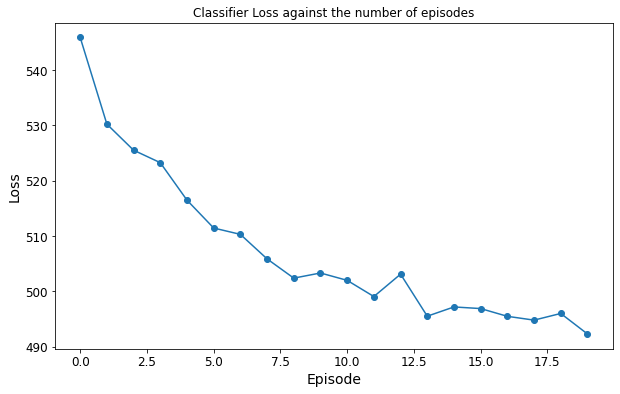

In [ ]:
if TRAINING:
  model_dense_utility.plot_losses()

In [ ]:
if TRAINING:
  model_dense_utility.save_model_weights()


Test set: Average loss: 2.2001, Accuracy: 134/324 (41%), F1 Score: 0.3418



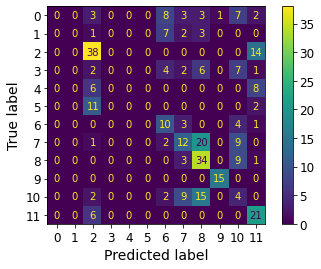

In [ ]:
model_dense_utility.test()

#### Results

Overall, considering the limited number of epochs and the simpler model architecture, our model has performed reasonably well, however, the results still show that the our model is only getting 41% accuracy with a F1 score of 0.3418. We can see from the confusion matrix, our model has done very well at classifying class 9. This is likely due to the uniqueness of this plankton species. The rest of the species have not done as well, with only around 60% of the classes even getting at least one classification correct. This may be because the similarity of some of the species of plankton have made it difficult for this model to accurately classify the plankton.

**Next steps:** 

To improve our result, I plan to develop a more complicated model by using a CNN. This will hopefully be able to distinguish between more complex features between each plankton species.

### CNN model

The CNN model architecture includes two convolutional layers, each followed by batch normalization, ReLU activation, and max pooling. The output is then flattened and passed through three fully connected layers with ReLU activation and a final softmax function to produce 12 output classes.

For the linear dense layers, I decided to use a similar architecture to AlexNet with three fully connected layers with 4096 neurons in the middle layer.

#### Setup CNN model

In [ ]:
class CNNModel(nn.Module):
    
  def __init__(self):
    super().__init__()

    # the decoder needs to follow the same structure as the encoder. 
    self.conv = nn.Sequential(collections.OrderedDict([
      ("Conv layer 1", nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1)),
      ("Batch norm 1", nn.BatchNorm2d(8)),
      ("Relu function 1", nn.ReLU(True)),
      ("Maxpool layer 1", nn.MaxPool2d(kernel_size=2, stride=2)),
      
      ("Conv layer 2", nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding=1)),
      ("Batch norm 2", nn.BatchNorm2d(16)),
      ("Relu function 2", nn.ReLU(True)),
      ("Maxpool layer 2", nn.MaxPool2d(kernel_size=2, stride=1)),
    ]))

    self.flatten = nn.Sequential(collections.OrderedDict([
      ("Flatten", nn.Flatten())
    ]))

    self.linear = nn.Sequential(collections.OrderedDict([
      ("Dense layer 1",nn.Linear(10000,4096)),
      ("Relu function 1", nn.ReLU(True)),
      ("Dense layer 2",nn.Linear(4096,4096)),
      ("Relu function 2", nn.ReLU(True)),
      ("Dense layer 3",nn.Linear(4096,12)),
      ("Softmax function 1",nn.Softmax(dim=1))
    ]))

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x

model_conv = CNNModel()


In [ ]:
if TRAINING:
  model_cnn_utility = ModelUtility(model_conv, 'model_conv', train_loader, valid_loader, combined_train_valid_loader, test_loader, n_epochs = 100, verbose=True)
else:
  model_cnn_utility = ModelUtility(model_conv, 'model_conv', train_loader, valid_loader, combined_train_valid_loader, test_loader, model_weights_path=f"{MODEL_WEIGHT_PATH}/model_conv_weights.pt", n_epochs = 100, verbose=True)

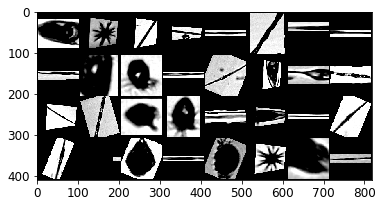

In [ ]:
if TRAINING:
  model_cnn_utility.show_first_batch_training()

#### Tune/train/test CNN model

In [ ]:
if TRAINING:
  model_cnn_utility.train_tuner()

[INFO 03-15 12:54:03] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-15 12:54:03] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-15 12:54:03] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]).
[INFO 03-15 12:54:03] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 03-15 12:54:03] ax.

{'lr': 0.2797987340656883, 'momentum': 0.25372951030731206}
2023-03-15 12:54:14.766441 Epoch 1, Training loss 536.6492624282837
2023-03-15 12:54:20.852018 Epoch 2, Training loss 519.7080248594284
2023-03-15 12:54:26.907067 Epoch 3, Training loss 517.8555519580841
2023-03-15 12:54:32.798899 Epoch 4, Training loss 513.1929267644882
2023-03-15 12:54:38.798395 Epoch 5, Training loss 514.1755264997482
2023-03-15 12:54:44.920229 Epoch 6, Training loss 511.8284898996353
2023-03-15 12:54:50.798688 Epoch 7, Training loss 508.8064250946045
2023-03-15 12:54:56.706090 Epoch 8, Training loss 504.82914543151855
2023-03-15 12:55:02.776390 Epoch 9, Training loss 503.3554389476776
2023-03-15 12:55:08.732891 Epoch 10, Training loss 500.797040104866
2023-03-15 12:55:14.659893 Epoch 11, Training loss 498.7547274827957
2023-03-15 12:55:20.702467 Epoch 12, Training loss 492.7674241065979
2023-03-15 12:55:26.701988 Epoch 13, Training loss 490.53145229816437
2023-03-15 12:55:32.547656 Epoch 14, Training loss 

[INFO 03-15 12:57:09] ax.service.managed_loop: Running optimization trial 2...
[WARNING 03-15 12:57:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 12:57:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 12:57:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 1 (type: <class 'int'>).
[WARNING 03-15 12:57:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.93703496 0.19216189]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 12:57:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBri

{'lr': 0.04676083334890421, 'momentum': 0.5381981298327446}
2023-03-15 12:57:15.184616 Epoch 1, Training loss 535.0649582147598
2023-03-15 12:57:21.263529 Epoch 2, Training loss 520.0676798820496
2023-03-15 12:57:27.223265 Epoch 3, Training loss 511.98559761047363
2023-03-15 12:57:33.098917 Epoch 4, Training loss 509.60136556625366
2023-03-15 12:57:39.147167 Epoch 5, Training loss 508.9031958580017
2023-03-15 12:57:45.202683 Epoch 6, Training loss 505.54381799697876
2023-03-15 12:57:51.120263 Epoch 7, Training loss 503.72463071346283
2023-03-15 12:57:57.152391 Epoch 8, Training loss 501.16395831108093
2023-03-15 12:58:03.228863 Epoch 9, Training loss 496.69823586940765
2023-03-15 12:58:09.090971 Epoch 10, Training loss 491.49202513694763
2023-03-15 12:58:15.080887 Epoch 11, Training loss 487.92883491516113
2023-03-15 12:58:21.163167 Epoch 12, Training loss 486.813668012619
2023-03-15 12:58:27.131404 Epoch 13, Training loss 480.7708216905594
2023-03-15 12:58:33.011279 Epoch 14, Training

[INFO 03-15 13:00:09] ax.service.managed_loop: Running optimization trial 3...
[WARNING 03-15 13:00:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 13:00:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 13:00:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 2 (type: <class 'int'>).
[WARNING 03-15 13:00:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.93703496 0.19216189]
 [0.43384244 0.54774766]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 13:00:09] ax.utils.common.kwargs: `<class 'ax.modelbri

{'lr': 0.0659362391322389, 'momentum': 0.8491283878684044}
2023-03-15 13:00:15.650567 Epoch 1, Training loss 583.825973033905
2023-03-15 13:00:21.731886 Epoch 2, Training loss 589.0073676109314
2023-03-15 13:00:27.627863 Epoch 3, Training loss 587.3511176109314
2023-03-15 13:00:33.555327 Epoch 4, Training loss 586.1636176109314
2023-03-15 13:00:39.654800 Epoch 5, Training loss 585.6011176109314
2023-03-15 13:00:45.586030 Epoch 6, Training loss 587.0698676109314
2023-03-15 13:00:51.508125 Epoch 7, Training loss 587.3198676109314
2023-03-15 13:00:57.568780 Epoch 8, Training loss 588.6323676109314
2023-03-15 13:01:03.524517 Epoch 9, Training loss 587.5698676109314
2023-03-15 13:01:09.389639 Epoch 10, Training loss 586.8823676109314
2023-03-15 13:01:15.408604 Epoch 11, Training loss 585.3823676109314
2023-03-15 13:01:21.510349 Epoch 12, Training loss 588.2886176109314
2023-03-15 13:01:27.374653 Epoch 13, Training loss 587.7261176109314
2023-03-15 13:01:33.324146 Epoch 14, Training loss 587

[INFO 03-15 13:03:09] ax.service.managed_loop: Running optimization trial 4...
[WARNING 03-15 13:03:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 13:03:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 13:03:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 3 (type: <class 'int'>).
[WARNING 03-15 13:03:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.93703496 0.19216189]
 [0.43384244 0.54774766]
 [0.53049746 0.93641048]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 13:03:09] ax.utils.common.kwa

{'lr': 0.31514723090922925, 'momentum': 0.1769229479134083}
2023-03-15 13:03:16.095850 Epoch 1, Training loss 546.3275909423828
2023-03-15 13:03:22.145645 Epoch 2, Training loss 517.8010934591293
2023-03-15 13:03:28.026130 Epoch 3, Training loss 513.9107714891434
2023-03-15 13:03:34.046211 Epoch 4, Training loss 514.9782147407532
2023-03-15 13:03:40.095957 Epoch 5, Training loss 510.6577001810074
2023-03-15 13:03:45.970921 Epoch 6, Training loss 505.08023476600647
2023-03-15 13:03:51.960393 Epoch 7, Training loss 503.31869208812714
2023-03-15 13:03:58.054999 Epoch 8, Training loss 500.9006994962692
2023-03-15 13:04:03.964192 Epoch 9, Training loss 493.81051671504974
2023-03-15 13:04:09.873773 Epoch 10, Training loss 494.3041076660156
2023-03-15 13:04:15.966011 Epoch 11, Training loss 493.15700364112854
2023-03-15 13:04:21.983685 Epoch 12, Training loss 492.0995740890503
2023-03-15 13:04:27.858366 Epoch 13, Training loss 489.0468975305557
2023-03-15 13:04:33.889028 Epoch 14, Training lo

[INFO 03-15 13:06:10] ax.service.managed_loop: Running optimization trial 5...
[WARNING 03-15 13:06:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 13:06:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 13:06:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 4 (type: <class 'int'>).
[WARNING 03-15 13:06:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.93703496 0.19216189]
 [0.43384244 0.54774766]
 [0.53049746 0.93641048]
 [0.97049706 0.09615368]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 13:0

{'lr': 0.19043480979155256, 'momentum': 0.12423589900135995}
2023-03-15 13:06:16.490183 Epoch 1, Training loss 535.085193157196
2023-03-15 13:06:22.421047 Epoch 2, Training loss 519.0039592981339
2023-03-15 13:06:28.357479 Epoch 3, Training loss 513.5199900865555
2023-03-15 13:06:34.426061 Epoch 4, Training loss 506.60991299152374
2023-03-15 13:06:40.440443 Epoch 5, Training loss 502.6913266181946
2023-03-15 13:06:46.333218 Epoch 6, Training loss 494.2077804803848
2023-03-15 13:06:52.388872 Epoch 7, Training loss 489.2826246023178
2023-03-15 13:06:58.599695 Epoch 8, Training loss 487.62092089653015
2023-03-15 13:07:04.510069 Epoch 9, Training loss 486.6752634048462
2023-03-15 13:07:10.524616 Epoch 10, Training loss 482.1641845703125
2023-03-15 13:07:16.640755 Epoch 11, Training loss 481.25064861774445
2023-03-15 13:07:22.557871 Epoch 12, Training loss 478.07950043678284
2023-03-15 13:07:28.475998 Epoch 13, Training loss 475.0088003873825
2023-03-15 13:07:34.536477 Epoch 14, Training lo

[INFO 03-15 13:09:11] ax.service.managed_loop: Running optimization trial 6...
[WARNING 03-15 13:09:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:09:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:09:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bd08e80> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:09:11] ax.utils.common.

{'lr': 0.01495966649403395, 'momentum': 0.4077467739432471}
2023-03-15 13:09:17.931139 Epoch 1, Training loss 550.1854724884033
2023-03-15 13:09:23.812705 Epoch 2, Training loss 522.4818366765976
2023-03-15 13:09:29.816739 Epoch 3, Training loss 515.8584342002869
2023-03-15 13:09:35.920272 Epoch 4, Training loss 516.0517283678055
2023-03-15 13:09:41.845065 Epoch 5, Training loss 513.3378281593323
2023-03-15 13:09:47.765107 Epoch 6, Training loss 510.8947480916977
2023-03-15 13:09:53.862647 Epoch 7, Training loss 509.9664124250412
2023-03-15 13:09:59.895099 Epoch 8, Training loss 506.8125389814377
2023-03-15 13:10:05.787496 Epoch 9, Training loss 502.8957049846649
2023-03-15 13:10:11.847782 Epoch 10, Training loss 504.06130611896515
2023-03-15 13:10:17.897330 Epoch 11, Training loss 499.88200652599335
2023-03-15 13:10:23.800857 Epoch 12, Training loss 498.26953852176666
2023-03-15 13:10:29.784515 Epoch 13, Training loss 496.29178535938263
2023-03-15 13:10:35.853106 Epoch 14, Training lo

[INFO 03-15 13:12:12] ax.service.managed_loop: Running optimization trial 7...
[WARNING 03-15 13:12:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:12:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:12:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bd15580> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:12:12] ax.utils.common.

{'lr': 0.35, 'momentum': 0.1}
2023-03-15 13:12:19.144938 Epoch 1, Training loss 539.465617775917
2023-03-15 13:12:25.042123 Epoch 2, Training loss 519.8245980739594
2023-03-15 13:12:31.149146 Epoch 3, Training loss 524.1365213394165
2023-03-15 13:12:37.246244 Epoch 4, Training loss 514.5042684078217
2023-03-15 13:12:43.128016 Epoch 5, Training loss 507.1325670480728
2023-03-15 13:12:49.130435 Epoch 6, Training loss 514.8140165805817
2023-03-15 13:12:55.234719 Epoch 7, Training loss 503.1549447774887
2023-03-15 13:13:01.135259 Epoch 8, Training loss 505.2807972431183
2023-03-15 13:13:07.104061 Epoch 9, Training loss 499.1556593179703
2023-03-15 13:13:13.155350 Epoch 10, Training loss 494.1166546344757
2023-03-15 13:13:19.098702 Epoch 11, Training loss 490.2975380420685
2023-03-15 13:13:25.001804 Epoch 12, Training loss 491.2142415046692
2023-03-15 13:13:31.059780 Epoch 13, Training loss 486.40168023109436
2023-03-15 13:13:37.153015 Epoch 14, Training loss 484.762508392334
2023-03-15 13:

[INFO 03-15 13:15:13] ax.service.managed_loop: Running optimization trial 8...
[WARNING 03-15 13:15:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:15:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:15:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bca3cd0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:15:13] ax.utils.common.

{'lr': 0.07667751348525523, 'momentum': 0.2015306648065187}
2023-03-15 13:15:20.381421 Epoch 1, Training loss 535.5110343694687
2023-03-15 13:15:26.357360 Epoch 2, Training loss 517.6086176633835
2023-03-15 13:15:32.445686 Epoch 3, Training loss 512.601109623909
2023-03-15 13:15:38.394107 Epoch 4, Training loss 509.81021308898926
2023-03-15 13:15:44.295602 Epoch 5, Training loss 504.81306540966034
2023-03-15 13:15:50.393919 Epoch 6, Training loss 504.6549150943756
2023-03-15 13:15:56.383432 Epoch 7, Training loss 498.38929557800293
2023-03-15 13:16:02.264940 Epoch 8, Training loss 498.3819988965988
2023-03-15 13:16:08.322912 Epoch 9, Training loss 498.4754660129547
2023-03-15 13:16:14.365551 Epoch 10, Training loss 494.2381184101105
2023-03-15 13:16:20.251460 Epoch 11, Training loss 489.20765459537506
2023-03-15 13:16:26.230206 Epoch 12, Training loss 481.1768321990967
2023-03-15 13:16:32.327558 Epoch 13, Training loss 475.89089179039
2023-03-15 13:16:38.261115 Epoch 14, Training loss 

[INFO 03-15 13:18:15] ax.service.managed_loop: Running optimization trial 9...
[WARNING 03-15 13:18:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:18:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:18:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc89520> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:18:15] ax.utils.common.

{'lr': 0.0797404710904028, 'momentum': 0.37404198407393086}
2023-03-15 13:18:21.911702 Epoch 1, Training loss 534.7751483917236
2023-03-15 13:18:28.014053 Epoch 2, Training loss 517.2101873159409
2023-03-15 13:18:34.033418 Epoch 3, Training loss 513.7522234916687
2023-03-15 13:18:39.915349 Epoch 4, Training loss 507.61456167697906
2023-03-15 13:18:45.915238 Epoch 5, Training loss 508.4834613800049
2023-03-15 13:18:51.987691 Epoch 6, Training loss 501.1239011287689
2023-03-15 13:18:57.847181 Epoch 7, Training loss 497.2692232131958
2023-03-15 13:19:03.814299 Epoch 8, Training loss 493.6303925514221
2023-03-15 13:19:09.897705 Epoch 9, Training loss 487.53411400318146
2023-03-15 13:19:15.842162 Epoch 10, Training loss 484.9429202079773
2023-03-15 13:19:21.736280 Epoch 11, Training loss 484.21489787101746
2023-03-15 13:19:27.825921 Epoch 12, Training loss 474.6911220550537
2023-03-15 13:19:33.827035 Epoch 13, Training loss 470.18196535110474
2023-03-15 13:19:39.752020 Epoch 14, Training lo

[INFO 03-15 13:21:16] ax.service.managed_loop: Running optimization trial 10...
[WARNING 03-15 13:21:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:21:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:21:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc0a370> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:21:16] ax.utils.common

{'lr': 0.09837728197614583, 'momentum': 0.1}
2023-03-15 13:21:22.966030 Epoch 1, Training loss 532.2084028720856
2023-03-15 13:21:29.067787 Epoch 2, Training loss 514.2743715047836
2023-03-15 13:21:35.003488 Epoch 3, Training loss 512.3914059400558
2023-03-15 13:21:40.909670 Epoch 4, Training loss 509.5291975736618
2023-03-15 13:21:47.055245 Epoch 5, Training loss 508.3717602491379
2023-03-15 13:21:53.060187 Epoch 6, Training loss 507.5669971704483
2023-03-15 13:21:58.973430 Epoch 7, Training loss 502.03321075439453
2023-03-15 13:22:05.021785 Epoch 8, Training loss 498.0028598308563
2023-03-15 13:22:11.098306 Epoch 9, Training loss 498.9170016050339
2023-03-15 13:22:17.035052 Epoch 10, Training loss 498.1689397096634
2023-03-15 13:22:23.055028 Epoch 11, Training loss 495.169105052948
2023-03-15 13:22:29.199943 Epoch 12, Training loss 491.6791933774948
2023-03-15 13:22:35.159081 Epoch 13, Training loss 483.0940282344818
2023-03-15 13:22:41.095765 Epoch 14, Training loss 482.459932088851

[INFO 03-15 13:24:17] ax.service.managed_loop: Running optimization trial 11...
[WARNING 03-15 13:24:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:24:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:24:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc25070> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:24:17] ax.utils.common

{'lr': 0.04750639260288672, 'momentum': 0.330891042586666}
2023-03-15 13:24:24.784013 Epoch 1, Training loss 536.8675092458725
2023-03-15 13:24:30.813189 Epoch 2, Training loss 519.7082582712173
2023-03-15 13:24:36.696002 Epoch 3, Training loss 513.1374659538269
2023-03-15 13:24:42.709333 Epoch 4, Training loss 506.9553825855255
2023-03-15 13:24:48.825058 Epoch 5, Training loss 506.0026741027832
2023-03-15 13:24:54.726230 Epoch 6, Training loss 504.1133179664612
2023-03-15 13:25:00.688277 Epoch 7, Training loss 501.0804990530014
2023-03-15 13:25:06.773881 Epoch 8, Training loss 499.64085042476654
2023-03-15 13:25:12.741204 Epoch 9, Training loss 495.55189645290375
2023-03-15 13:25:18.734104 Epoch 10, Training loss 491.95739471912384
2023-03-15 13:25:24.833558 Epoch 11, Training loss 493.51460361480713
2023-03-15 13:25:30.863308 Epoch 12, Training loss 489.3216358423233
2023-03-15 13:25:36.772172 Epoch 13, Training loss 490.3202854394913
2023-03-15 13:25:42.816195 Epoch 14, Training los

[INFO 03-15 13:27:19] ax.service.managed_loop: Running optimization trial 12...
[WARNING 03-15 13:27:19] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:27:19] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:27:19] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc09100> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:27:19] ax.utils.common

{'lr': 0.03232529931684757, 'momentum': 0.1}
2023-03-15 13:27:26.838032 Epoch 1, Training loss 549.9480167627335
2023-03-15 13:27:32.784908 Epoch 2, Training loss 522.5556577444077
2023-03-15 13:27:38.713602 Epoch 3, Training loss 518.3048361539841
2023-03-15 13:27:44.819469 Epoch 4, Training loss 514.7219234704971
2023-03-15 13:27:50.822250 Epoch 5, Training loss 508.8669184446335
2023-03-15 13:27:56.681179 Epoch 6, Training loss 511.288419008255
2023-03-15 13:28:02.733443 Epoch 7, Training loss 506.8908294439316
2023-03-15 13:28:08.794154 Epoch 8, Training loss 505.2427270412445
2023-03-15 13:28:14.743316 Epoch 9, Training loss 500.29048228263855
2023-03-15 13:28:20.774142 Epoch 10, Training loss 501.70516300201416
2023-03-15 13:28:26.895309 Epoch 11, Training loss 497.31627559661865
2023-03-15 13:28:32.804235 Epoch 12, Training loss 494.0683538913727
2023-03-15 13:28:38.745036 Epoch 13, Training loss 494.09041929244995
2023-03-15 13:28:44.809353 Epoch 14, Training loss 491.402048110

[INFO 03-15 13:30:21] ax.service.managed_loop: Running optimization trial 13...
[WARNING 03-15 13:30:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:30:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:30:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bbd4fd0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:30:21] ax.utils.common

{'lr': 0.10896612435618211, 'momentum': 0.2569207030607389}
2023-03-15 13:30:28.682445 Epoch 1, Training loss 532.4492508172989
2023-03-15 13:30:34.572552 Epoch 2, Training loss 520.2388495206833
2023-03-15 13:30:40.609497 Epoch 3, Training loss 516.066712975502
2023-03-15 13:30:46.685309 Epoch 4, Training loss 511.14314556121826
2023-03-15 13:30:52.649845 Epoch 5, Training loss 508.59976041316986
2023-03-15 13:30:58.637205 Epoch 6, Training loss 506.43088948726654
2023-03-15 13:31:04.751177 Epoch 7, Training loss 503.0201075077057
2023-03-15 13:31:10.691838 Epoch 8, Training loss 500.09895980358124
2023-03-15 13:31:16.616080 Epoch 9, Training loss 490.9964337348938
2023-03-15 13:31:22.767245 Epoch 10, Training loss 489.07697200775146
2023-03-15 13:31:28.779127 Epoch 11, Training loss 485.9529023170471
2023-03-15 13:31:34.688055 Epoch 12, Training loss 484.6177268028259
2023-03-15 13:31:40.760082 Epoch 13, Training loss 481.87786519527435
2023-03-15 13:31:46.818272 Epoch 14, Training l

[INFO 03-15 13:33:23] ax.service.managed_loop: Running optimization trial 14...
[WARNING 03-15 13:33:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:33:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:33:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bbee3d0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:33:23] ax.utils.common

{'lr': 0.10600359125490978, 'momentum': 0.4862226602704818}
2023-03-15 13:33:30.643146 Epoch 1, Training loss 535.915046453476
2023-03-15 13:33:36.603141 Epoch 2, Training loss 519.4046741724014
2023-03-15 13:33:42.711058 Epoch 3, Training loss 508.74522948265076
2023-03-15 13:33:48.655043 Epoch 4, Training loss 507.0477534532547
2023-03-15 13:33:54.536070 Epoch 5, Training loss 496.22386848926544
2023-03-15 13:34:00.627859 Epoch 6, Training loss 494.28752422332764
2023-03-15 13:34:06.634987 Epoch 7, Training loss 491.5951256752014
2023-03-15 13:34:12.518173 Epoch 8, Training loss 484.52000319957733
2023-03-15 13:34:18.554572 Epoch 9, Training loss 487.42103576660156
2023-03-15 13:34:24.595812 Epoch 10, Training loss 478.6402975320816
2023-03-15 13:34:30.503626 Epoch 11, Training loss 480.51951456069946
2023-03-15 13:34:36.437127 Epoch 12, Training loss 475.0527299642563
2023-03-15 13:34:42.531274 Epoch 13, Training loss 473.3045747280121
2023-03-15 13:34:48.426524 Epoch 14, Training l

[INFO 03-15 13:36:24] ax.service.managed_loop: Running optimization trial 15...
[WARNING 03-15 13:36:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:36:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:36:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bca31c0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:36:24] ax.utils.common

{'lr': 0.06140553537429835, 'momentum': 0.4449019794974902}
2023-03-15 13:36:31.300694 Epoch 1, Training loss 531.9518542289734
2023-03-15 13:36:37.316792 Epoch 2, Training loss 520.345906496048
2023-03-15 13:36:43.335920 Epoch 3, Training loss 514.7868512868881
2023-03-15 13:36:49.217336 Epoch 4, Training loss 510.1851282119751
2023-03-15 13:36:55.158314 Epoch 5, Training loss 507.48150193691254
2023-03-15 13:37:01.207885 Epoch 6, Training loss 504.0661224126816
2023-03-15 13:37:07.096337 Epoch 7, Training loss 501.56366777420044
2023-03-15 13:37:13.028215 Epoch 8, Training loss 498.68588149547577
2023-03-15 13:37:19.104494 Epoch 9, Training loss 495.74402618408203
2023-03-15 13:37:25.072235 Epoch 10, Training loss 495.51254439353943
2023-03-15 13:37:30.937948 Epoch 11, Training loss 488.027534365654
2023-03-15 13:37:36.947985 Epoch 12, Training loss 480.84374129772186
2023-03-15 13:37:42.963899 Epoch 13, Training loss 477.81176006793976
2023-03-15 13:37:48.818344 Epoch 14, Training l

[INFO 03-15 13:39:25] ax.service.managed_loop: Running optimization trial 16...
[WARNING 03-15 13:39:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:39:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:39:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bd08850> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:39:25] ax.utils.common

{'lr': 0.35, 'momentum': 0.5431844160133392}
2023-03-15 13:39:31.807190 Epoch 1, Training loss 549.2927227020264
2023-03-15 13:39:37.882058 Epoch 2, Training loss 550.280113697052
2023-03-15 13:39:43.855124 Epoch 3, Training loss 585.1198027133942
2023-03-15 13:39:49.679581 Epoch 4, Training loss 599.2261152267456
2023-03-15 13:39:55.673765 Epoch 5, Training loss 596.1008367538452
2023-03-15 13:40:01.734972 Epoch 6, Training loss 597.5691883563995
2023-03-15 13:40:07.587137 Epoch 7, Training loss 597.9133148193359
2023-03-15 13:40:13.529268 Epoch 8, Training loss 598.0691871643066
2023-03-15 13:40:19.578612 Epoch 9, Training loss 596.9761176109314
2023-03-15 13:40:25.459703 Epoch 10, Training loss 596.725613117218
2023-03-15 13:40:31.332376 Epoch 11, Training loss 597.1636176109314
2023-03-15 13:40:37.415772 Epoch 12, Training loss 598.2573676109314
2023-03-15 13:40:43.343281 Epoch 13, Training loss 597.9448676109314
2023-03-15 13:40:49.218636 Epoch 14, Training loss 598.4136176109314


[INFO 03-15 13:42:25] ax.service.managed_loop: Running optimization trial 17...
[WARNING 03-15 13:42:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:42:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:42:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bb5fe80> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:42:25] ax.utils.common

{'lr': 0.01, 'momentum': 0.7935723122376267}
2023-03-15 13:42:32.310170 Epoch 1, Training loss 540.7419853210449
2023-03-15 13:42:38.394712 Epoch 2, Training loss 519.2292945384979
2023-03-15 13:42:44.270074 Epoch 3, Training loss 513.8282806873322
2023-03-15 13:42:50.148231 Epoch 4, Training loss 509.35629522800446
2023-03-15 13:42:56.225874 Epoch 5, Training loss 506.84884226322174
2023-03-15 13:43:02.161758 Epoch 6, Training loss 501.21347522735596
2023-03-15 13:43:08.056893 Epoch 7, Training loss 501.0659794807434
2023-03-15 13:43:14.158205 Epoch 8, Training loss 500.7131778001785
2023-03-15 13:43:20.197934 Epoch 9, Training loss 495.920844912529
2023-03-15 13:43:26.070587 Epoch 10, Training loss 495.74872183799744
2023-03-15 13:43:32.036602 Epoch 11, Training loss 493.4511263370514
2023-03-15 13:43:38.107222 Epoch 12, Training loss 492.9418195486069
2023-03-15 13:43:43.978140 Epoch 13, Training loss 487.153990149498
2023-03-15 13:43:49.855901 Epoch 14, Training loss 487.6740750074

[INFO 03-15 13:45:25] ax.service.managed_loop: Running optimization trial 18...
[WARNING 03-15 13:45:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:45:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:45:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc891f0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:45:25] ax.utils.common

{'lr': 0.01, 'momentum': 0.1}
2023-03-15 13:45:32.992819 Epoch 1, Training loss 566.257791519165
2023-03-15 13:45:38.988455 Epoch 2, Training loss 544.9131898880005
2023-03-15 13:45:44.856126 Epoch 3, Training loss 528.8703244924545
2023-03-15 13:45:50.849077 Epoch 4, Training loss 522.5215944051743
2023-03-15 13:45:56.885093 Epoch 5, Training loss 518.6548815965652
2023-03-15 13:46:02.743337 Epoch 6, Training loss 514.5977749824524
2023-03-15 13:46:08.696286 Epoch 7, Training loss 513.3836084604263
2023-03-15 13:46:14.751027 Epoch 8, Training loss 511.16245996952057
2023-03-15 13:46:20.678446 Epoch 9, Training loss 511.00374376773834
2023-03-15 13:46:26.574460 Epoch 10, Training loss 509.4185012578964
2023-03-15 13:46:32.636782 Epoch 11, Training loss 510.17741787433624
2023-03-15 13:46:38.622899 Epoch 12, Training loss 507.28175127506256
2023-03-15 13:46:44.496263 Epoch 13, Training loss 507.4296736717224
2023-03-15 13:46:50.496029 Epoch 14, Training loss 506.05403757095337
2023-03-1

[INFO 03-15 13:48:26] ax.service.managed_loop: Running optimization trial 19...
[WARNING 03-15 13:48:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:48:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:48:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bbbc100> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:48:26] ax.utils.common

{'lr': 0.06827562797316458, 'momentum': 0.28476839507095164}
2023-03-15 13:48:34.054489 Epoch 1, Training loss 532.1836318969727
2023-03-15 13:48:39.965813 Epoch 2, Training loss 517.0349206924438
2023-03-15 13:48:45.903489 Epoch 3, Training loss 516.334799528122
2023-03-15 13:48:51.941022 Epoch 4, Training loss 512.4691543579102
2023-03-15 13:48:57.902642 Epoch 5, Training loss 505.7217061519623
2023-03-15 13:49:03.770504 Epoch 6, Training loss 505.5170900821686
2023-03-15 13:49:09.781247 Epoch 7, Training loss 500.1380169391632
2023-03-15 13:49:15.796692 Epoch 8, Training loss 500.6177946329117
2023-03-15 13:49:21.650940 Epoch 9, Training loss 496.2802183628082
2023-03-15 13:49:27.604117 Epoch 10, Training loss 492.2322417497635
2023-03-15 13:49:33.657631 Epoch 11, Training loss 491.3625662326813
2023-03-15 13:49:39.529535 Epoch 12, Training loss 490.3187824487686
2023-03-15 13:49:45.471955 Epoch 13, Training loss 492.43241119384766
2023-03-15 13:49:51.526896 Epoch 14, Training loss 

[INFO 03-15 13:51:27] ax.service.managed_loop: Running optimization trial 20...
[WARNING 03-15 13:51:27] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 13:51:27] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 13:51:27] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bb85d00> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 13:51:27] ax.utils.common

{'lr': 0.14825572590117944, 'momentum': 0.1}
2023-03-15 13:51:34.519318 Epoch 1, Training loss 533.8384288549423
2023-03-15 13:51:40.394103 Epoch 2, Training loss 517.8361257314682
2023-03-15 13:51:46.358226 Epoch 3, Training loss 509.2943959236145
2023-03-15 13:51:52.414303 Epoch 4, Training loss 506.2951076030731
2023-03-15 13:51:58.281048 Epoch 5, Training loss 506.2395476102829
2023-03-15 13:52:04.174879 Epoch 6, Training loss 500.3856635093689
2023-03-15 13:52:10.280009 Epoch 7, Training loss 496.7282335758209
2023-03-15 13:52:16.216011 Epoch 8, Training loss 499.90735626220703
2023-03-15 13:52:22.085492 Epoch 9, Training loss 488.0732204914093
2023-03-15 13:52:28.117068 Epoch 10, Training loss 486.05247962474823
2023-03-15 13:52:34.129427 Epoch 11, Training loss 484.8703598976135
2023-03-15 13:52:39.981568 Epoch 12, Training loss 479.7438051700592
2023-03-15 13:52:45.944104 Epoch 13, Training loss 474.7335675954819
2023-03-15 13:52:51.997511 Epoch 14, Training loss 472.6535667181

[WARNING 03-15 13:54:28] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `model_constructor` to be of type TModelConstructor. Got <function get_and_fit_model at 0x7f6bd1ebd040> (type: <class 'function'>).
[WARNING 03-15 13:54:28] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `model_predictor` to be of type TModelPredictor. Got <function predict_from_model at 0x7f6bd1e6a790> (type: <class 'function'>).
[WARNING 03-15 13:54:28] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `acqf_constructor` to be of type TAcqfConstructor. Got <function get_NEI at 0x7f6bd1e6aa60> (type: <class 'function'>).
[WARNING 03-15 13:54:28] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `acqf_optimizer` to be of type TOptimizer. Got <function scipy_optimizer at 0x7f6bd1e72550> (type: <class 'function'>).
[WARNING 03-15 13:54:28] ax.utils.c

{'lr': 0.19043480979155256, 'momentum': 0.12423589900135995}


In [ ]:
if TRAINING:
  model_cnn_utility.plot_best_objective()

In [ ]:
if TRAINING:
  model_cnn_utility.train()

2023-03-15 13:54:35.406894 Epoch 1, Training loss 530.8062677383423
2023-03-15 13:54:41.254127 Epoch 2, Training loss 520.7732225656509
2023-03-15 13:54:47.309757 Epoch 3, Training loss 513.9250222444534
2023-03-15 13:54:53.353953 Epoch 4, Training loss 513.7698814868927
2023-03-15 13:54:59.213313 Epoch 5, Training loss 507.7934387922287
2023-03-15 13:55:05.206483 Epoch 6, Training loss 502.9329377412796
2023-03-15 13:55:11.250845 Epoch 7, Training loss 501.5673590898514
2023-03-15 13:55:17.099533 Epoch 8, Training loss 499.77718937397003
2023-03-15 13:55:23.052506 Epoch 9, Training loss 495.5671161413193
2023-03-15 13:55:29.092982 Epoch 10, Training loss 488.640313744545
2023-03-15 13:55:35.015440 Epoch 11, Training loss 489.0007709264755
2023-03-15 13:55:40.882213 Epoch 12, Training loss 485.2914124727249
2023-03-15 13:55:46.931865 Epoch 13, Training loss 478.7653443813324
2023-03-15 13:55:52.964215 Epoch 14, Training loss 475.4753085374832
2023-03-15 13:55:58.805732 Epoch 15, Traini

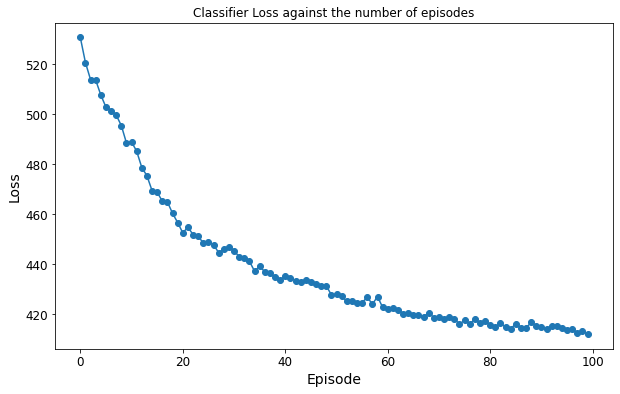

In [ ]:
if TRAINING:
  model_cnn_utility.plot_losses()

In [ ]:
if TRAINING:
  model_cnn_utility.save_model_weights()


Test set: Average loss: 2.0091, Accuracy: 198/324 (61%), F1 Score: 0.5495



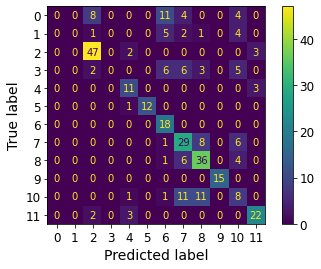

In [ ]:
model_cnn_utility.test()

#### Results

We can see overall the results have greatly improved since using a CNN, with our model getting 61% accuracy and a F1 score of 0.5495. In addition to updating the model architecture we increased the number of training episodes to 100 episodes. Our classifier loss graph shows this has helped the model converge. The confusion matrix shows there has been a large improvement compared to the first model with now only three classes with no correct predictions. Class 0,1 and 3 are currently still the sticking points with our classifier. It seems that the model is largely getting confused between these three classes and the other classes with a similar straight line shape.

**Next steps** 

To improve the model further, I plan to use the pre-trained model AlexNet, which has been trained on a million image from ImageNet database and use transfer learning. Using transfer learning with a pre-trained model like AlexNet can help us work with our smaller dataset, as the model has already learned relevant features from a large dataset like ImageNet. 

### AlexNet

AlexNet architecture consists of 5 convolutional layers, 3 max-pooling layers, 2 normalisation layers, 2 fully connected layers, and 1 softmax layer. We utilised transfer learning to train the pre-trained model with our data to classify plankton.

#### Setup dataset and dataloader for AlexNet

Due to the specific pre-processing steps required by AlexNet, we have to set up new datasets and dataloader for the model.


In [ ]:
train_dataset = PlanktonDataset(X_train, y_train, train_data_augmentation=True, alexnet=True)
test_dataset = PlanktonDataset(X_test, y_test, alexnet=True)
valid_dataset = PlanktonDataset(X_valid, y_valid, alexnet=True)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, sampler=train_dataset.weighted_random_sampler())
valid_loader = torch.utils.data.DataLoader(valid_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

In [ ]:
combined_train_valid_data = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])
combined_train_valid_loader = torch.utils.data.DataLoader(combined_train_valid_data, batch_size = 32, sampler=train_dataset.weighted_random_sampler()) 

#### Setup AlexNet model

In [ ]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Freeze all layers except the last fully connected layer - this make sure that the weights set from the original ALexNet training will be kept.
for param in alexnet.parameters():
    param.requires_grad = False
alexnet.classifier[6] = nn.Linear(4096, 12) # Change the output neurons to 12 (the number of classes we have)

In [ ]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
if TRAINING:
  model_alexnet_utility = ModelUtility(alexnet, 'model_alexnet', train_loader, valid_loader, combined_train_valid_loader, test_loader, n_epochs=30, lr=0.001, momentum=0.9, verbose=True)
else:
  model_alexnet_utility = ModelUtility(alexnet, 'model_alexnet', train_loader, valid_loader, combined_train_valid_loader, test_loader, model_weights_path=f"{MODEL_WEIGHT_PATH}/model_alexnet_weights.pt", n_epochs=30, lr=0.001, momentum=0.9, verbose=True)

#### Tune/train/test AlexNet model

In [ ]:
if TRAINING:
  model_alexnet_utility.train_tuner()

[INFO 03-15 14:21:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-15 14:21:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-15 14:21:22] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]).
[INFO 03-15 14:21:22] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 03-15 14:21:22] ax.

{'lr': 0.017925691177349618, 'momentum': 0.25810766220092773}
2023-03-15 14:21:32.603630 Epoch 1, Training loss 354.6202177107334
2023-03-15 14:21:44.018299 Epoch 2, Training loss 335.9763420820236
2023-03-15 14:21:53.832397 Epoch 3, Training loss 300.19474145770073
2023-03-15 14:22:05.545714 Epoch 4, Training loss 300.4521170258522
2023-03-15 14:22:15.023332 Epoch 5, Training loss 291.9432240128517
2023-03-15 14:22:26.838778 Epoch 6, Training loss 287.2642543911934
2023-03-15 14:22:36.319620 Epoch 7, Training loss 276.24224504828453
2023-03-15 14:22:48.016449 Epoch 8, Training loss 284.99491411447525
2023-03-15 14:22:57.847338 Epoch 9, Training loss 282.50349420309067
2023-03-15 14:23:09.260231 Epoch 10, Training loss 265.1678548157215
2023-03-15 14:23:19.435051 Epoch 11, Training loss 249.97020825743675
2023-03-15 14:23:31.065749 Epoch 12, Training loss 265.0306246429682
2023-03-15 14:23:41.212575 Epoch 13, Training loss 266.037576854229
2023-03-15 14:23:52.162389 Epoch 14, Training 

[INFO 03-15 14:26:43] ax.service.managed_loop: Running optimization trial 2...
[WARNING 03-15 14:26:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 14:26:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 14:26:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 1 (type: <class 'int'>).
[WARNING 03-15 14:26:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.1641611  0.19763458]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 14:26:43] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBri

{'lr': 0.05527174815382106, 'momentum': 0.3441221877932549}
2023-03-15 14:26:54.065721 Epoch 1, Training loss 1188.644860625267
2023-03-15 14:27:04.594930 Epoch 2, Training loss 935.1751559972763
2023-03-15 14:27:15.262087 Epoch 3, Training loss 942.949112534523
2023-03-15 14:27:26.160285 Epoch 4, Training loss 908.4588878750801
2023-03-15 14:27:36.363764 Epoch 5, Training loss 837.4380022287369
2023-03-15 14:27:47.528061 Epoch 6, Training loss 788.3419262766838
2023-03-15 14:27:57.502976 Epoch 7, Training loss 864.5453687161207
2023-03-15 14:28:09.193959 Epoch 8, Training loss 756.965951859951
2023-03-15 14:28:18.690173 Epoch 9, Training loss 798.4751415252686
2023-03-15 14:28:30.540858 Epoch 10, Training loss 764.1962002962828
2023-03-15 14:28:39.869619 Epoch 11, Training loss 754.3963502049446
2023-03-15 14:28:51.585874 Epoch 12, Training loss 779.0576502382755
2023-03-15 14:29:01.112838 Epoch 13, Training loss 773.8189194202423
2023-03-15 14:29:12.866178 Epoch 14, Training loss 784

[INFO 03-15 14:32:03] ax.service.managed_loop: Running optimization trial 3...
[WARNING 03-15 14:32:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 14:32:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 14:32:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 2 (type: <class 'int'>).
[WARNING 03-15 14:32:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.1641611  0.19763458]
 [0.48087466 0.30515273]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 14:32:03] ax.utils.common.kwargs: `<class 'ax.modelbri

{'lr': 0.08715578112851206, 'momentum': 0.6282956160604953}
2023-03-15 14:32:15.174033 Epoch 1, Training loss 2296.6548941135406
2023-03-15 14:32:24.937794 Epoch 2, Training loss 1793.944887638092
2023-03-15 14:32:36.443098 Epoch 3, Training loss 1955.0510828495026
2023-03-15 14:32:46.460542 Epoch 4, Training loss 1712.7920005619526
2023-03-15 14:32:57.569252 Epoch 5, Training loss 1872.7552270889282
2023-03-15 14:33:07.917536 Epoch 6, Training loss 1744.9679380655289
2023-03-15 14:33:18.667149 Epoch 7, Training loss 1859.9388589859009
2023-03-15 14:33:29.319636 Epoch 8, Training loss 1643.8971962928772
2023-03-15 14:33:39.883897 Epoch 9, Training loss 1863.2901334762573
2023-03-15 14:33:50.781846 Epoch 10, Training loss 1665.746123790741
2023-03-15 14:34:01.041914 Epoch 11, Training loss 1838.331568479538
2023-03-15 14:34:12.426576 Epoch 12, Training loss 1672.1240235567093
2023-03-15 14:34:22.220838 Epoch 13, Training loss 1678.1502149105072
2023-03-15 14:34:33.829858 Epoch 14, Train

[INFO 03-15 14:37:24] ax.service.managed_loop: Running optimization trial 4...
[WARNING 03-15 14:37:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 14:37:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 14:37:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 3 (type: <class 'int'>).
[WARNING 03-15 14:37:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.1641611  0.19763458]
 [0.48087466 0.30515273]
 [0.60897329 0.66036952]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 14:37:24] ax.utils.common.kwa

{'lr': 0.021203820055978106, 'momentum': 0.24710065126419067}
2023-03-15 14:37:35.403650 Epoch 1, Training loss 464.32033383846283
2023-03-15 14:37:45.481620 Epoch 2, Training loss 367.9542381465435
2023-03-15 14:37:56.835953 Epoch 3, Training loss 319.65340572595596
2023-03-15 14:38:06.792195 Epoch 4, Training loss 328.953340947628
2023-03-15 14:38:18.573362 Epoch 5, Training loss 328.06075444817543
2023-03-15 14:38:27.992935 Epoch 6, Training loss 314.53046214580536
2023-03-15 14:38:39.830264 Epoch 7, Training loss 314.6652318239212
2023-03-15 14:38:49.331599 Epoch 8, Training loss 290.1429853737354
2023-03-15 14:39:01.033619 Epoch 9, Training loss 293.26582396030426
2023-03-15 14:39:10.939499 Epoch 10, Training loss 304.18060821294785
2023-03-15 14:39:22.254584 Epoch 11, Training loss 297.6094146370888
2023-03-15 14:39:32.415610 Epoch 12, Training loss 306.1514956653118
2023-03-15 14:39:43.445914 Epoch 13, Training loss 315.1503997147083
2023-03-15 14:39:53.898663 Epoch 14, Training

[INFO 03-15 14:42:46] ax.service.managed_loop: Running optimization trial 5...
[WARNING 03-15 14:42:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Optional[int]. Got None (type: <class 'NoneType'>).
[WARNING 03-15 14:42:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 03-15 14:42:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 4 (type: <class 'int'>).
[WARNING 03-15 14:42:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Optional[numpy.ndarray]. Got [[0.1641611  0.19763458]
 [0.48087466 0.30515273]
 [0.60897329 0.66036952]
 [0.21139879 0.18387581]] (type: <class 'numpy.ndarray'>).
[WARNING 03-15 14:4

{'lr': 0.011916476071339183, 'momentum': 0.32829976454377174}
2023-03-15 14:42:56.647951 Epoch 1, Training loss 306.0985262989998
2023-03-15 14:43:07.226437 Epoch 2, Training loss 255.19444662332535
2023-03-15 14:43:18.404853 Epoch 3, Training loss 249.7481785416603
2023-03-15 14:43:28.545978 Epoch 4, Training loss 242.18261763453484
2023-03-15 14:43:40.075826 Epoch 5, Training loss 226.23164689540863
2023-03-15 14:43:49.776372 Epoch 6, Training loss 222.49608105421066
2023-03-15 14:44:01.622012 Epoch 7, Training loss 227.00496077537537
2023-03-15 14:44:11.014468 Epoch 8, Training loss 220.25475719571114
2023-03-15 14:44:22.970745 Epoch 9, Training loss 201.4880530834198
2023-03-15 14:44:32.548799 Epoch 10, Training loss 211.85229308903217
2023-03-15 14:44:44.176769 Epoch 11, Training loss 218.3260134458542
2023-03-15 14:44:54.149147 Epoch 12, Training loss 216.65626856684685
2023-03-15 14:45:05.424404 Epoch 13, Training loss 221.26265707612038
2023-03-15 14:45:15.890303 Epoch 14, Trai

[INFO 03-15 14:48:08] ax.service.managed_loop: Running optimization trial 6...
[WARNING 03-15 14:48:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 14:48:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 14:48:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b4ae777c0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 14:48:08] ax.utils.common.

{'lr': 0.32167186650615376, 'momentum': 0.37553871189672383}
2023-03-15 14:48:19.508694 Epoch 1, Training loss 6453.054023504257
2023-03-15 14:48:30.477759 Epoch 2, Training loss 5741.344032287598
2023-03-15 14:48:41.066188 Epoch 3, Training loss 5384.128040194511
2023-03-15 14:48:51.797611 Epoch 4, Training loss 5272.5110375881195
2023-03-15 14:49:02.795146 Epoch 5, Training loss 5106.255840539932
2023-03-15 14:49:13.133391 Epoch 6, Training loss 5025.772312879562
2023-03-15 14:49:24.677517 Epoch 7, Training loss 4821.883576393127
2023-03-15 14:49:34.509199 Epoch 8, Training loss 4992.211345911026
2023-03-15 14:49:46.400254 Epoch 9, Training loss 4573.188129901886
2023-03-15 14:49:55.851067 Epoch 10, Training loss 5114.005383014679
2023-03-15 14:50:07.719221 Epoch 11, Training loss 4550.52654671669
2023-03-15 14:50:17.362830 Epoch 12, Training loss 4538.728529930115
2023-03-15 14:50:29.138560 Epoch 13, Training loss 4828.6483154296875
2023-03-15 14:50:38.970492 Epoch 14, Training loss

[INFO 03-15 14:53:32] ax.service.managed_loop: Running optimization trial 7...
[WARNING 03-15 14:53:32] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 14:53:32] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 14:53:32] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba4068940> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 14:53:32] ax.utils.common.

{'lr': 0.034195283549548955, 'momentum': 0.6708292300585046}
2023-03-15 14:53:43.503200 Epoch 1, Training loss 931.5767652988434
2023-03-15 14:53:54.296057 Epoch 2, Training loss 765.9710423350334
2023-03-15 14:54:05.223113 Epoch 3, Training loss 790.2574430704117
2023-03-15 14:54:15.462923 Epoch 4, Training loss 763.2640652954578
2023-03-15 14:54:26.729581 Epoch 5, Training loss 776.9322581887245
2023-03-15 14:54:36.747069 Epoch 6, Training loss 761.8864152431488
2023-03-15 14:54:48.148574 Epoch 7, Training loss 789.9617829322815
2023-03-15 14:54:57.943917 Epoch 8, Training loss 710.1885310411453
2023-03-15 14:55:09.740285 Epoch 9, Training loss 729.889653801918
2023-03-15 14:55:19.176394 Epoch 10, Training loss 735.9833863973618
2023-03-15 14:55:31.179742 Epoch 11, Training loss 669.0800419449806
2023-03-15 14:55:40.720664 Epoch 12, Training loss 685.4533843398094
2023-03-15 14:55:52.600978 Epoch 13, Training loss 718.231714040041
2023-03-15 14:56:02.410433 Epoch 14, Training loss 70

[INFO 03-15 14:58:56] ax.service.managed_loop: Running optimization trial 8...
[WARNING 03-15 14:58:56] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 14:58:56] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 14:58:56] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba409bbb0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 14:58:56] ax.utils.common.

{'lr': 0.08800380845573669, 'momentum': 0.9}
2023-03-15 14:59:05.919859 Epoch 1, Training loss 6076.484629392624
2023-03-15 14:59:17.365173 Epoch 2, Training loss 5623.918486118317
2023-03-15 14:59:27.273201 Epoch 3, Training loss 5644.693179130554
2023-03-15 14:59:38.510513 Epoch 4, Training loss 5933.637875556946
2023-03-15 14:59:48.569865 Epoch 5, Training loss 5975.867551803589
2023-03-15 14:59:59.620934 Epoch 6, Training loss 5483.013036251068
2023-03-15 15:00:10.106368 Epoch 7, Training loss 5633.834750175476
2023-03-15 15:00:20.698613 Epoch 8, Training loss 6226.5214257240295
2023-03-15 15:00:31.522046 Epoch 9, Training loss 6025.098096847534
2023-03-15 15:00:41.932288 Epoch 10, Training loss 5479.279622077942
2023-03-15 15:00:53.137695 Epoch 11, Training loss 5196.757433891296
2023-03-15 15:01:03.204065 Epoch 12, Training loss 6119.493921518326
2023-03-15 15:01:14.596093 Epoch 13, Training loss 5865.83670091629
2023-03-15 15:01:24.286879 Epoch 14, Training loss 5613.38752841949

[INFO 03-15 15:04:16] ax.service.managed_loop: Running optimization trial 9...
[WARNING 03-15 15:04:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:04:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:04:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9ba9eb50> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:04:16] ax.utils.common.

{'lr': 0.01, 'momentum': 0.7338854054486664}
2023-03-15 15:04:27.280903 Epoch 1, Training loss 360.77464669942856
2023-03-15 15:04:39.050554 Epoch 2, Training loss 304.25600826740265
2023-03-15 15:04:48.560168 Epoch 3, Training loss 312.68850433826447
2023-03-15 15:05:00.403374 Epoch 4, Training loss 290.11914190649986
2023-03-15 15:05:09.914125 Epoch 5, Training loss 288.97744742035866
2023-03-15 15:05:21.727038 Epoch 6, Training loss 288.3185087144375
2023-03-15 15:05:31.580136 Epoch 7, Training loss 280.4106568098068
2023-03-15 15:05:43.008643 Epoch 8, Training loss 290.86608777940273
2023-03-15 15:05:53.305826 Epoch 9, Training loss 274.07287895679474
2023-03-15 15:06:04.536979 Epoch 10, Training loss 270.55458725988865
2023-03-15 15:06:15.110500 Epoch 11, Training loss 259.0687528550625
2023-03-15 15:06:25.921663 Epoch 12, Training loss 276.4998237490654
2023-03-15 15:06:36.664461 Epoch 13, Training loss 278.67724481225014
2023-03-15 15:06:47.183466 Epoch 14, Training loss 262.890

[INFO 03-15 15:09:39] ax.service.managed_loop: Running optimization trial 10...
[WARNING 03-15 15:09:39] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:09:39] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:09:39] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b4b3a8820> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:09:39] ax.utils.common

{'lr': 0.08783744251518717, 'momentum': 0.3829970362170595}
2023-03-15 15:09:50.670722 Epoch 1, Training loss 1827.3152869939804
2023-03-15 15:10:01.754221 Epoch 2, Training loss 1528.491176366806
2023-03-15 15:10:12.077792 Epoch 3, Training loss 1474.1723716259003
2023-03-15 15:10:23.384617 Epoch 4, Training loss 1331.1896431446075
2023-03-15 15:10:33.184366 Epoch 5, Training loss 1337.9539949893951
2023-03-15 15:10:44.787443 Epoch 6, Training loss 1272.0184979438782
2023-03-15 15:10:54.427826 Epoch 7, Training loss 1339.668613910675
2023-03-15 15:11:06.272016 Epoch 8, Training loss 1220.182326078415
2023-03-15 15:11:15.792089 Epoch 9, Training loss 1232.7708387672901
2023-03-15 15:11:27.635021 Epoch 10, Training loss 1356.0291435718536
2023-03-15 15:11:37.048046 Epoch 11, Training loss 1210.132469177246
2023-03-15 15:11:48.836486 Epoch 12, Training loss 1295.7970307469368
2023-03-15 15:11:58.527987 Epoch 13, Training loss 1332.538800895214
2023-03-15 15:12:10.036285 Epoch 14, Trainin

[INFO 03-15 15:15:01] ax.service.managed_loop: Running optimization trial 11...
[WARNING 03-15 15:15:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:15:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:15:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba405ed90> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:15:01] ax.utils.common

{'lr': 0.06130447851310609, 'momentum': 0.5671555949107084}
2023-03-15 15:15:13.489242 Epoch 1, Training loss 1399.1927418708801
2023-03-15 15:15:24.032015 Epoch 2, Training loss 1172.7892377376556
2023-03-15 15:15:34.932864 Epoch 3, Training loss 1139.9770933389664
2023-03-15 15:15:45.752224 Epoch 4, Training loss 1151.5189979076385
2023-03-15 15:15:56.264228 Epoch 5, Training loss 1042.2365162968636
2023-03-15 15:16:07.467248 Epoch 6, Training loss 1045.2743017673492
2023-03-15 15:16:17.720055 Epoch 7, Training loss 1081.8071279525757
2023-03-15 15:16:29.419783 Epoch 8, Training loss 1067.1270213127136
2023-03-15 15:16:39.179496 Epoch 9, Training loss 993.6624168157578
2023-03-15 15:16:51.210811 Epoch 10, Training loss 1041.9572364091873
2023-03-15 15:17:00.611171 Epoch 11, Training loss 1104.6512465178967
2023-03-15 15:17:12.643783 Epoch 12, Training loss 1046.2839674949646
2023-03-15 15:17:22.429170 Epoch 13, Training loss 1025.8812592029572
2023-03-15 15:17:34.003368 Epoch 14, Tra

[INFO 03-15 15:20:26] ax.service.managed_loop: Running optimization trial 12...
[WARNING 03-15 15:20:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:20:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:20:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba405ed30> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:20:26] ax.utils.common

{'lr': 0.06749751396339876, 'momentum': 0.1}
2023-03-15 15:20:38.681299 Epoch 1, Training loss 1310.2987635731697
2023-03-15 15:20:48.861877 Epoch 2, Training loss 1043.2410271205008
2023-03-15 15:21:00.027198 Epoch 3, Training loss 1040.7655688524246
2023-03-15 15:21:10.256652 Epoch 4, Training loss 1021.6342230439186
2023-03-15 15:21:21.127408 Epoch 5, Training loss 844.3906736373901
2023-03-15 15:21:31.694533 Epoch 6, Training loss 915.2481873035431
2023-03-15 15:21:42.371912 Epoch 7, Training loss 950.7744199037552
2023-03-15 15:21:53.249229 Epoch 8, Training loss 879.461591720581
2023-03-15 15:22:03.776986 Epoch 9, Training loss 950.7497485280037
2023-03-15 15:22:14.973993 Epoch 10, Training loss 875.6641972362995
2023-03-15 15:22:25.161875 Epoch 11, Training loss 951.5488631725311
2023-03-15 15:22:36.696427 Epoch 12, Training loss 906.9571460485458
2023-03-15 15:22:46.415836 Epoch 13, Training loss 862.1039302945137
2023-03-15 15:22:58.287813 Epoch 14, Training loss 855.566475987

[INFO 03-15 15:25:49] ax.service.managed_loop: Running optimization trial 13...
[WARNING 03-15 15:25:49] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:25:49] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:25:49] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9b8a08b0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:25:49] ax.utils.common

{'lr': 0.026256056619035125, 'momentum': 0.44341407041817116}
2023-03-15 15:26:02.155876 Epoch 1, Training loss 546.464485168457
2023-03-15 15:26:11.856054 Epoch 2, Training loss 450.36843344569206
2023-03-15 15:26:23.297911 Epoch 3, Training loss 440.12367713451385
2023-03-15 15:26:33.308700 Epoch 4, Training loss 429.9918431341648
2023-03-15 15:26:44.515054 Epoch 5, Training loss 434.39618372917175
2023-03-15 15:26:54.777265 Epoch 6, Training loss 403.6914623081684
2023-03-15 15:27:05.733381 Epoch 7, Training loss 402.93447360396385
2023-03-15 15:27:16.424180 Epoch 8, Training loss 400.4727741777897
2023-03-15 15:27:27.049666 Epoch 9, Training loss 400.3915776312351
2023-03-15 15:27:37.839036 Epoch 10, Training loss 371.1634785234928
2023-03-15 15:27:48.092308 Epoch 11, Training loss 412.7204216122627
2023-03-15 15:27:59.362153 Epoch 12, Training loss 393.9979605823755
2023-03-15 15:28:09.258022 Epoch 13, Training loss 412.5520656108856
2023-03-15 15:28:20.676201 Epoch 14, Training l

[INFO 03-15 15:31:12] ax.service.managed_loop: Running optimization trial 14...
[WARNING 03-15 15:31:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:31:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:31:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9ba890d0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:31:12] ax.utils.common

{'lr': 0.22874312369015487, 'momentum': 0.7691695744618215}
2023-03-15 15:31:25.015653 Epoch 1, Training loss 8039.392292261124
2023-03-15 15:31:34.567875 Epoch 2, Training loss 7739.2548828125
2023-03-15 15:31:46.480122 Epoch 3, Training loss 7331.045640945435
2023-03-15 15:31:56.180825 Epoch 4, Training loss 6890.240357398987
2023-03-15 15:32:07.937029 Epoch 5, Training loss 6725.32240486145
2023-03-15 15:32:18.079795 Epoch 6, Training loss 6782.738564014435
2023-03-15 15:32:29.369378 Epoch 7, Training loss 6385.658232915215
2023-03-15 15:32:39.690509 Epoch 8, Training loss 7144.05110168457
2023-03-15 15:32:50.649407 Epoch 9, Training loss 6909.839487552643
2023-03-15 15:33:01.312739 Epoch 10, Training loss 6723.465847969055
2023-03-15 15:33:12.059672 Epoch 11, Training loss 6856.748038768768
2023-03-15 15:33:23.030855 Epoch 12, Training loss 6852.342759847641
2023-03-15 15:33:33.364267 Epoch 13, Training loss 6541.92866230011
2023-03-15 15:33:44.795071 Epoch 14, Training loss 6395.6

[INFO 03-15 15:36:37] ax.service.managed_loop: Running optimization trial 15...
[WARNING 03-15 15:36:37] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:36:37] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:36:37] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc08cd0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:36:37] ax.utils.common

{'lr': 0.01, 'momentum': 0.4892949366013867}
2023-03-15 15:36:49.993875 Epoch 1, Training loss 299.0847815275192
2023-03-15 15:36:59.754208 Epoch 2, Training loss 241.37618866562843
2023-03-15 15:37:11.703082 Epoch 3, Training loss 242.00434893369675
2023-03-15 15:37:21.090335 Epoch 4, Training loss 217.35796409845352
2023-03-15 15:37:32.954498 Epoch 5, Training loss 235.3938990533352
2023-03-15 15:37:42.590881 Epoch 6, Training loss 219.70348425209522
2023-03-15 15:37:54.261126 Epoch 7, Training loss 228.79200890660286
2023-03-15 15:38:04.348047 Epoch 8, Training loss 221.87358132004738
2023-03-15 15:38:15.717467 Epoch 9, Training loss 218.74234664440155
2023-03-15 15:38:26.042099 Epoch 10, Training loss 218.1545223891735
2023-03-15 15:38:37.048348 Epoch 11, Training loss 216.85456162691116
2023-03-15 15:38:47.720932 Epoch 12, Training loss 201.52924832701683
2023-03-15 15:38:58.359394 Epoch 13, Training loss 208.63835856318474
2023-03-15 15:39:09.433061 Epoch 14, Training loss 210.42

[INFO 03-15 15:42:01] ax.service.managed_loop: Running optimization trial 16...
[WARNING 03-15 15:42:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:42:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:42:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9bc08cd0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:42:01] ax.utils.common

{'lr': 0.015129567010563706, 'momentum': 0.5245956406434938}
2023-03-15 15:42:13.193255 Epoch 1, Training loss 372.3102312684059
2023-03-15 15:42:23.486719 Epoch 2, Training loss 335.1167130470276
2023-03-15 15:42:34.705184 Epoch 3, Training loss 300.7760238945484
2023-03-15 15:42:44.593483 Epoch 4, Training loss 303.49789920449257
2023-03-15 15:42:56.384988 Epoch 5, Training loss 283.4356621950865
2023-03-15 15:43:05.880522 Epoch 6, Training loss 279.3814716935158
2023-03-15 15:43:17.770663 Epoch 7, Training loss 282.34499579668045
2023-03-15 15:43:27.292209 Epoch 8, Training loss 289.1302447617054
2023-03-15 15:43:39.009602 Epoch 9, Training loss 293.95764538645744
2023-03-15 15:43:48.990572 Epoch 10, Training loss 278.0770701467991
2023-03-15 15:44:00.345669 Epoch 11, Training loss 272.7548443675041
2023-03-15 15:44:10.496750 Epoch 12, Training loss 259.19104355573654
2023-03-15 15:44:21.622340 Epoch 13, Training loss 288.3683353960514
2023-03-15 15:44:32.103914 Epoch 14, Training l

[INFO 03-15 15:47:24] ax.service.managed_loop: Running optimization trial 17...
[WARNING 03-15 15:47:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:47:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:47:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b9b794700> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:47:24] ax.utils.common

{'lr': 0.01, 'momentum': 0.4293878130742329}
2023-03-15 15:47:35.682951 Epoch 1, Training loss 287.95719200372696
2023-03-15 15:47:46.388758 Epoch 2, Training loss 246.0141972899437
2023-03-15 15:47:57.368066 Epoch 3, Training loss 238.96846002340317
2023-03-15 15:48:07.722670 Epoch 4, Training loss 224.63762620091438
2023-03-15 15:48:18.797195 Epoch 5, Training loss 220.06681498885155
2023-03-15 15:48:28.946373 Epoch 6, Training loss 216.50130438804626
2023-03-15 15:48:40.424922 Epoch 7, Training loss 213.568641602993
2023-03-15 15:48:50.148221 Epoch 8, Training loss 221.16938191652298
2023-03-15 15:49:02.013545 Epoch 9, Training loss 207.26817971467972
2023-03-15 15:49:11.514366 Epoch 10, Training loss 207.37434692680836
2023-03-15 15:49:23.331424 Epoch 11, Training loss 205.39573022723198
2023-03-15 15:49:32.713526 Epoch 12, Training loss 207.7341931760311
2023-03-15 15:49:44.416520 Epoch 13, Training loss 206.54404571652412
2023-03-15 15:49:54.185887 Epoch 14, Training loss 205.964

[INFO 03-15 15:52:47] ax.service.managed_loop: Running optimization trial 18...
[WARNING 03-15 15:52:47] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:52:47] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:52:47] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba40a20d0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:52:47] ax.utils.common

{'lr': 0.013031369160399103, 'momentum': 0.45002836182705674}
2023-03-15 15:52:58.521474 Epoch 1, Training loss 320.87249052524567
2023-03-15 15:53:09.913792 Epoch 2, Training loss 271.15345641970634
2023-03-15 15:53:20.127875 Epoch 3, Training loss 264.47139924764633
2023-03-15 15:53:31.202694 Epoch 4, Training loss 246.40002691745758
2023-03-15 15:53:41.669694 Epoch 5, Training loss 247.75901213288307
2023-03-15 15:53:52.362432 Epoch 6, Training loss 230.51720160245895
2023-03-15 15:54:03.218145 Epoch 7, Training loss 232.6558340191841
2023-03-15 15:54:13.596087 Epoch 8, Training loss 235.88596269488335
2023-03-15 15:54:24.827444 Epoch 9, Training loss 235.09052148461342
2023-03-15 15:54:34.868496 Epoch 10, Training loss 224.3576143682003
2023-03-15 15:54:46.531546 Epoch 11, Training loss 233.35542500019073
2023-03-15 15:54:56.135793 Epoch 12, Training loss 229.86297225952148
2023-03-15 15:55:07.981556 Epoch 13, Training loss 222.12777137756348
2023-03-15 15:55:17.349731 Epoch 14, Tr

[INFO 03-15 15:58:10] ax.service.managed_loop: Running optimization trial 19...
[WARNING 03-15 15:58:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 15:58:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 15:58:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6ba4068070> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 15:58:10] ax.utils.common

{'lr': 0.01, 'momentum': 0.5412208561344439}
2023-03-15 15:58:20.810597 Epoch 1, Training loss 290.1698706448078
2023-03-15 15:58:32.608760 Epoch 2, Training loss 244.14937728643417
2023-03-15 15:58:42.445311 Epoch 3, Training loss 247.27850049734116
2023-03-15 15:58:53.816782 Epoch 4, Training loss 240.50778502225876
2023-03-15 15:59:03.899576 Epoch 5, Training loss 229.43705290555954
2023-03-15 15:59:15.062025 Epoch 6, Training loss 220.02228593826294
2023-03-15 15:59:25.369858 Epoch 7, Training loss 222.5287043452263
2023-03-15 15:59:36.295727 Epoch 8, Training loss 229.97155514359474
2023-03-15 15:59:46.836900 Epoch 9, Training loss 227.11642608046532
2023-03-15 15:59:57.439498 Epoch 10, Training loss 212.59634059667587
2023-03-15 16:00:08.322518 Epoch 11, Training loss 217.18997430801392
2023-03-15 16:00:18.677164 Epoch 12, Training loss 213.9526843726635
2023-03-15 16:00:29.658040 Epoch 13, Training loss 220.75515042245388
2023-03-15 16:00:39.821320 Epoch 14, Training loss 214.35

[INFO 03-15 16:03:33] ax.service.managed_loop: Running optimization trial 20...
[WARNING 03-15 16:03:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type Experiment. Got Experiment(None) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 03-15 16:03:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type SearchSpace. Got SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.01, 0.35], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.1, 0.9])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 03-15 16:03:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type Data. Got <ax.core.data.Data object at 0x7f6b4b3a8df0> (type: <class 'ax.core.data.Data'>).
[WARNING 03-15 16:03:33] ax.utils.common

{'lr': 0.023247183440711035, 'momentum': 0.9}
2023-03-15 16:03:43.554032 Epoch 1, Training loss 1601.827910542488
2023-03-15 16:03:55.070798 Epoch 2, Training loss 1672.2894034385681
2023-03-15 16:04:04.680422 Epoch 3, Training loss 1402.6812269687653
2023-03-15 16:04:16.729044 Epoch 4, Training loss 1518.7981877326965
2023-03-15 16:04:26.110733 Epoch 5, Training loss 1383.4019031524658
2023-03-15 16:04:37.920771 Epoch 6, Training loss 1564.7051787376404
2023-03-15 16:04:47.429370 Epoch 7, Training loss 1488.6379388570786
2023-03-15 16:04:59.158815 Epoch 8, Training loss 1494.6699110269547
2023-03-15 16:05:08.792302 Epoch 9, Training loss 1418.6282725334167
2023-03-15 16:05:20.385110 Epoch 10, Training loss 1476.2455164194107
2023-03-15 16:05:30.327028 Epoch 11, Training loss 1525.1010490059853
2023-03-15 16:05:41.687355 Epoch 12, Training loss 1586.568854689598
2023-03-15 16:05:51.973534 Epoch 13, Training loss 1375.9639142751694
2023-03-15 16:06:02.852156 Epoch 14, Training loss 1591

[WARNING 03-15 16:08:54] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `model_constructor` to be of type TModelConstructor. Got <function get_and_fit_model at 0x7f6bd1ebd040> (type: <class 'function'>).
[WARNING 03-15 16:08:54] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `model_predictor` to be of type TModelPredictor. Got <function predict_from_model at 0x7f6bd1e6a790> (type: <class 'function'>).
[WARNING 03-15 16:08:54] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `acqf_constructor` to be of type TAcqfConstructor. Got <function get_NEI at 0x7f6bd1e6aa60> (type: <class 'function'>).
[WARNING 03-15 16:08:54] ax.utils.common.kwargs: `<class 'ax.models.torch.botorch.BotorchModel'>` expected argument `acqf_optimizer` to be of type TOptimizer. Got <function scipy_optimizer at 0x7f6bd1e72550> (type: <class 'function'>).
[WARNING 03-15 16:08:54] ax.utils.c

{'lr': 0.01, 'momentum': 0.4293878130742329}


In [ ]:
if TRAINING:
  model_alexnet_utility.plot_best_objective()

In [ ]:
if TRAINING:
  model_alexnet_utility.train()

2023-03-15 17:36:26.405743 Epoch 1, Training loss 259.19783970713615
2023-03-15 17:36:39.154181 Epoch 2, Training loss 201.98919171094894
2023-03-15 17:36:49.201592 Epoch 3, Training loss 191.4129979610443
2023-03-15 17:37:00.802153 Epoch 4, Training loss 184.2232687175274
2023-03-15 17:37:11.109400 Epoch 5, Training loss 177.97442185878754
2023-03-15 17:37:22.462000 Epoch 6, Training loss 170.95839193463326
2023-03-15 17:37:33.646857 Epoch 7, Training loss 171.25094363093376
2023-03-15 17:37:44.646756 Epoch 8, Training loss 170.33909359574318
2023-03-15 17:37:55.701726 Epoch 9, Training loss 168.13766783475876
2023-03-15 17:38:06.499333 Epoch 10, Training loss 168.7557252049446
2023-03-15 17:38:17.781926 Epoch 11, Training loss 162.00959587097168
2023-03-15 17:38:28.151771 Epoch 12, Training loss 165.57986271381378
2023-03-15 17:38:39.847894 Epoch 13, Training loss 162.494117051363
2023-03-15 17:38:49.733777 Epoch 14, Training loss 158.20450875163078
2023-03-15 17:39:01.921168 Epoch 1

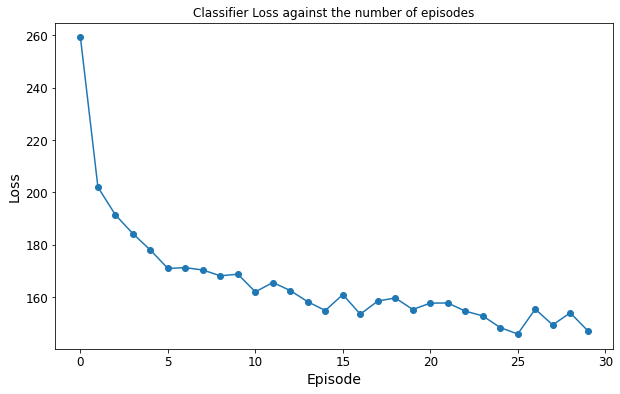

In [ ]:
if TRAINING:
  model_alexnet_utility.plot_losses()

In [ ]:
if TRAINING:
  model_alexnet_utility.save_model_weights()


Test set: Average loss: 1.7283, Accuracy: 219/324 (68%), F1 Score: 0.6409



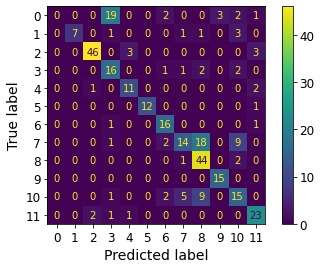

In [ ]:
model_alexnet_utility.test()

#### Results

The results from using AlexNet shows that although the model is still not perfect it has improved, especially with class 1 and 3 which are now classifying the majority of the samples in each class correctly. The accuracy of our model has increased to 68% with a F1 score of 0.6409. We have also required fewer episodes to have the model converge compared to the previous model, the CNN. 

The results from class 7 show a reduced in accuracy compared to the previous model. We can see the model often misclassifies the plankton with class 8 and 10, both plankton species with a similar straight line shape. 

Lastly, we can see the model still is struggling to classify class 0, with no correct classifications for this class and instead largely misclassifying the plankton to class 3. This is different to the previous two models which were misclassifying the plankton with class 2 and 6. This may suggest that the different pre-processing steps may have helped provide a better representation of each plankton as class 3 is a lot more similar to class 0 that class 2 and 6 are.